# Data pre-processing

In [1]:
## LOAD MODULES

# Data frame, arithmetical operation and plotting
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Preprocessing and data splitting
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

# Imbalanced learning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set seed for future reference
seed = 42

In [3]:
 # Read as data frame
 data = pd.read_csv("data.csv")
 data.info()
 data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   AGE         10295 non-null  float64
 3   HOMEKIDS    10302 non-null  int64  
 4   YOJ         9754 non-null   float64
 5   INCOME      9732 non-null   object 
 6   PARENT1     10302 non-null  object 
 7   HOME_VAL    9727 non-null   object 
 8   MSTATUS     10302 non-null  object 
 9   GENDER      10302 non-null  object 
 10  EDUCATION   10302 non-null  object 
 11  OCCUPATION  9637 non-null   object 
 12  TRAVTIME    10302 non-null  int64  
 13  CAR_USE     10302 non-null  object 
 14  BLUEBOOK    10302 non-null  object 
 15  TIF         10302 non-null  int64  
 16  CAR_TYPE    10302 non-null  object 
 17  RED_CAR     10302 non-null  object 
 18  OLDCLAIM    10302 non-null  object 
 19  CLM_FREQ    10302 non-nul

,ID,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,...,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG
0,63581743,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,...,11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0
1,132761049,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,...,1,Minivan,yes,$0,0,No,0,$0,1.0,0
2,921317019,0,48.0,0,11.0,"$52,881",No,$0,z_No,M,...,1,Van,yes,$0,0,No,2,$0,10.0,0
3,727598473,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,...,4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0
4,450221861,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,...,7,Minivan,yes,$0,0,No,0,$0,6.0,0


In [4]:
# Clean columns containing currencies
data_orig        = data.copy() # Preserve the original data
currencies       = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM", "CLM_AMT"]
data[currencies] = data[currencies].replace(
    "[\$,]", "", regex=True
).astype("float") # np.nan does not work with int

In [5]:
# Clean string dtypes
string = ["MSTATUS", "GENDER", "EDUCATION", "CAR_TYPE", "OCCUPATION", "CAR_USE"]
data[string] = data[string].replace(
    "^z_", "", regex=True
).astype("string")

In [6]:
# Convert columns with Yes/No entries into boolean dtypes
boolean       = ["PARENT1", "MSTATUS", "RED_CAR", "REVOKED"]
data[boolean] = data[boolean].apply(
    lambda col: [True if i.lower() == "yes" else False for i in col]
)

In [7]:
# Set `CLAIM_FLAG` as a boolean
data.CLAIM_FLAG = data.CLAIM_FLAG.astype("bool")

# Exploratory Data Analysis 1

## Distribution plot

Column removal: success


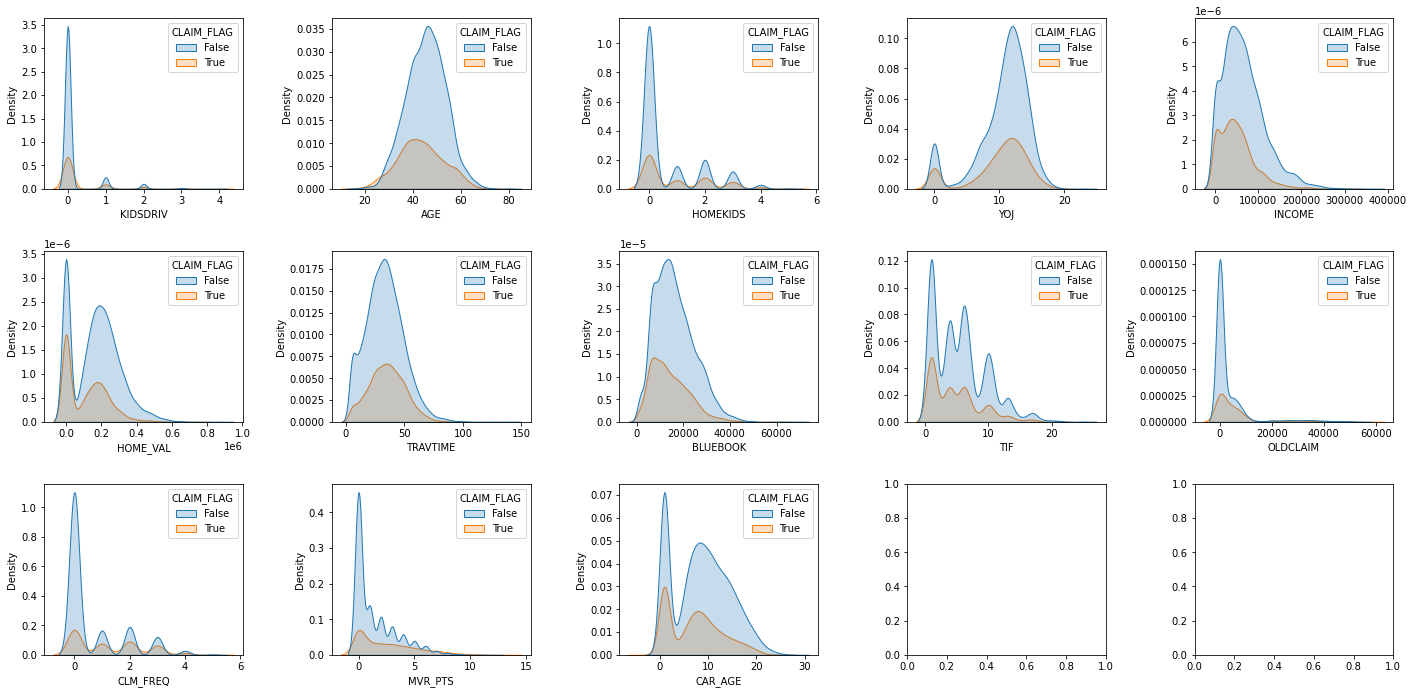

In [8]:
# Get numeric data
numerics = data.select_dtypes(["int64", "float64"]).columns.tolist()

try:
    numerics.remove("CLM_AMT")
    numerics.remove("ID")
    print("Column removal: success")
except ValueError:
    print("Requested columns are unavailable to remove")

# Descriptive statistics on numeric data
data.describe()

# Density plot on numeric data
nrow    = 3
ncol    = 5
rows    = [0]*ncol + [1]*ncol + [2]*ncol
cols    = [i for i in range(ncol)]*nrow
fig, ax = plt.subplots(nrow, ncol, figsize=[20, 10])

for row, col, colname in zip(rows, cols, numerics):
    sns.kdeplot(
        colname, hue="CLAIM_FLAG", fill="CLAIM_FLAG", data=data, ax=ax[row, col]
    )

plt.tight_layout(pad=2)
plt.show()

## Correlation

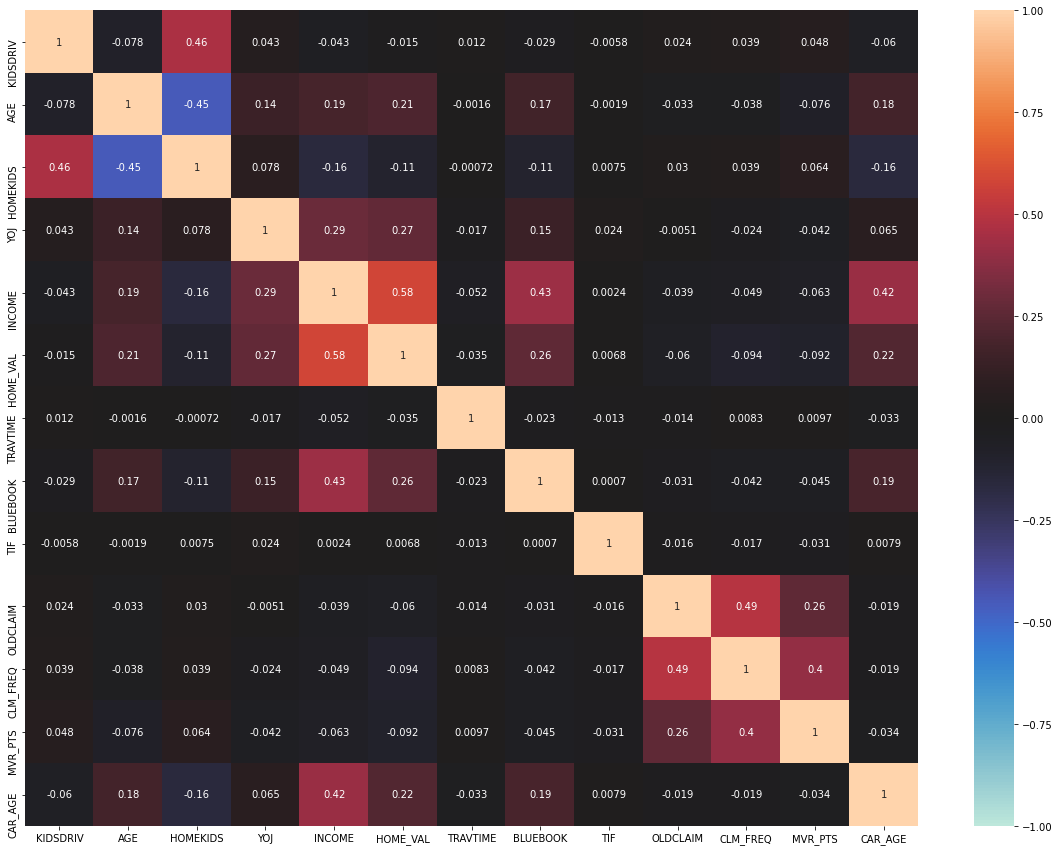

In [9]:
# Measure correlation on numeric data
plt.figure(figsize=[20, 15])
sns.heatmap(data[numerics].corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

## Education and Gender

<AxesSubplot:xlabel='EDUCATION', ylabel='no_claim'>

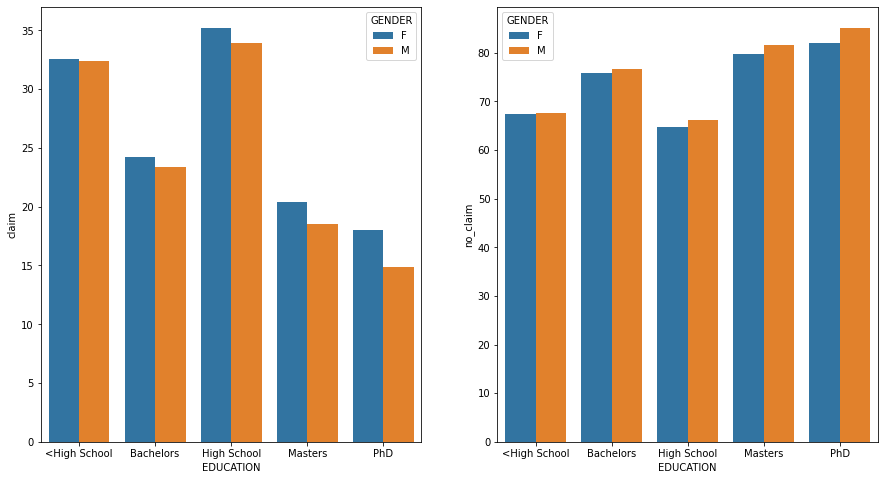

In [10]:
# Create a pivot table describing the total number of claim per categorical data
cat_pivot = pd.pivot_table(
    data, values="ID", columns="CLAIM_FLAG", index=["EDUCATION", "GENDER"],
    aggfunc="count"
).reset_index()

cat_pivot["total"] = cat_pivot[[0, 1]].apply(sum, axis=1)

cat_pivot["no_claim"] = cat_pivot[0] / cat_pivot.total * 100
cat_pivot["claim"]    = cat_pivot[1] / cat_pivot.total * 100

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.barplot(x="EDUCATION", y="claim", hue="GENDER", data=cat_pivot, ax=ax[0])
sns.barplot(x="EDUCATION", y="no_claim", hue="GENDER", data=cat_pivot, ax=ax[1])

## Bluebook & Car Type

In [11]:
# Creating pivot table comparing bluebook and car type
data_blue = pd.pivot_table(
    data,
    index = ['CAR_TYPE'],
    values='BLUEBOOK',
    aggfunc={'BLUEBOOK':'mean'}
).reset_index().sort_values('BLUEBOOK', ascending=False).reset_index(drop=True)

data_blue.BLUEBOOK = data_blue.BLUEBOOK.round(2)

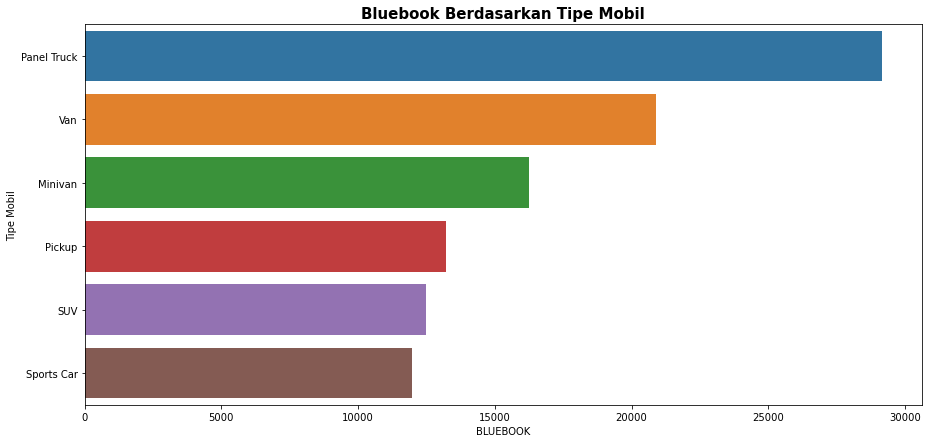

In [12]:
# Barplot
plt.figure(figsize=(15,7))
plt.title('Bluebook Berdasarkan Tipe Mobil', fontweight='bold', fontsize=15)
sns.barplot(y='CAR_TYPE',x='BLUEBOOK', data=data_blue, orient='h')

plt.ylabel('Tipe Mobil')

plt.show();

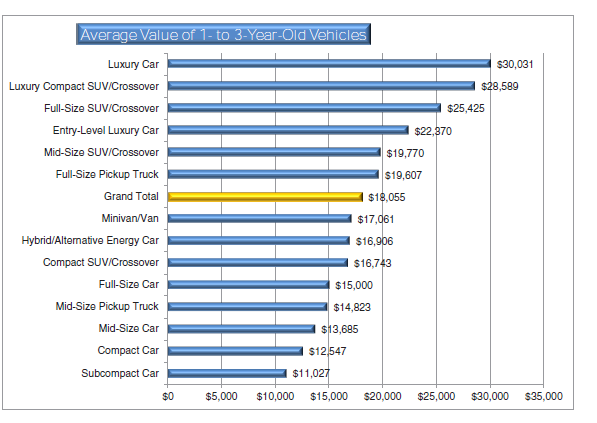

>NOTES:
Apabila dibandingkan dengan data yang ada, panel truck memiliki nilai bluebook tertinggi, ini berbeda dengan grafik kelley bluebook (diambil di tahun 2013).
Pada kelley bluebook, valuasi terbesar dimiliki oleh luxury car diikuti oleh luxury SUV dan full-size SUV. Hal ini mungkin terjadi dikarenakan umur atau kondisi jenis kendaraan tersebut buruk sehingga memiliki valuasi bluebook yang rendah.

## Car Type & Old Claim

In [13]:
# Car_type with oldclaim
data_old = pd.pivot_table(
    data,
    index   = ['CAR_TYPE'],
    values  = 'OLDCLAIM',
    aggfunc = {'OLDCLAIM':'mean'}
).reset_index().sort_values('OLDCLAIM', ascending=False).reset_index(drop=True)

data_old.OLDCLAIM = data_old.OLDCLAIM.round(2)

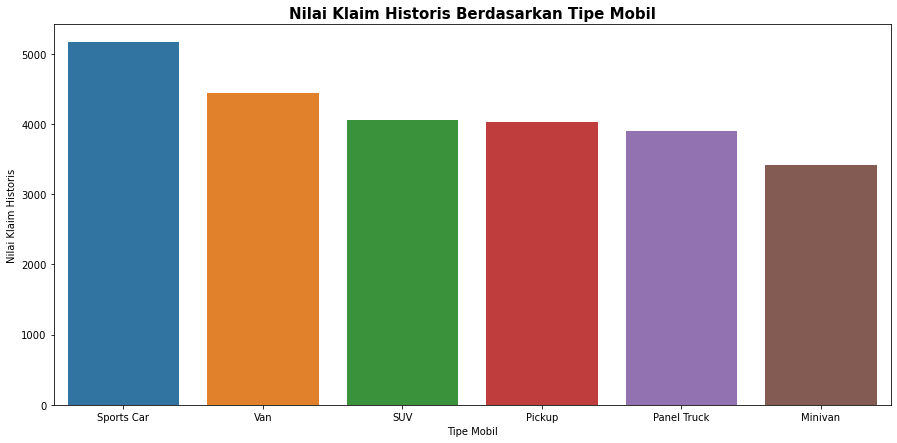

In [14]:
# Barplot
plt.figure(figsize=(15,7))
plt.title('Nilai Klaim Historis Berdasarkan Tipe Mobil', fontweight='bold', fontsize=15)
sns.barplot(x='CAR_TYPE',y='OLDCLAIM', data=data_old)

plt.ylabel('Nilai Klaim Historis')
plt.xlabel('Tipe Mobil')

plt.show();

>NOTES:
Secara historis nilai oldclaim terbesar dimiliki oleh jenis kendaraan 'Sports Car' berbanding terbalik dengan nilai bluebook.

## Old Claim & Current Claim

In [15]:
# OLD CLAIM with CLAIM_FLAG
data_oflag = pd.pivot_table(
    data,
    index = ['CLAIM_FLAG'],
    values='OLDCLAIM',
    aggfunc={'OLDCLAIM':'mean'}
).reset_index().sort_values('OLDCLAIM', ascending=False).reset_index(drop=True)

data_oflag.OLDCLAIM = data_oflag.OLDCLAIM.round(2)

No handles with labels found to put in legend.


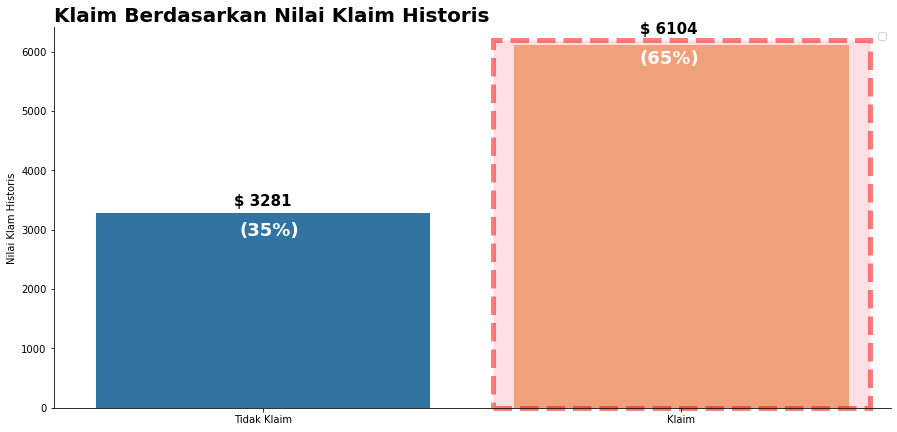

In [16]:
# Barplot
fig,ax = plt.subplots(1,figsize=(15,7))

#ax.set_title('OLDCLAIM VS CLAIM FLAG', fontweight='bold', fontsize=15)
sns.barplot(x='CLAIM_FLAG',y='OLDCLAIM', data=data_oflag,)

ax.set_ylabel('Nilai Klam Historis')
ax.set_xlabel('')

# Add the rectangle
rect = Rectangle( (0.55,0), 0.9, 6200, linestyle = 'dashed', ec='red', 
                 facecolor='pink', alpha=0.5, lw=5, clip_on=False, fill=1)
ax.add_patch(rect)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#show text
plt.text(-0.07,3400,s='$ 3281', fontweight='bold',fontsize=15)
plt.text(-0.055,2900,s='(35%)', fontweight='bold',fontsize=18, color='white')
plt.text(0.9,6300,s='$ 6104', fontweight='bold',fontsize=15)
plt.text(0.9,5800,s='(65%)', fontweight='bold',fontsize=18, color='white')

plt.text(x=-0.5,y=6500, s='Klaim Berdasarkan Nilai Klaim Historis', fontweight='bold',
         fontsize=20, ha='left')
#plt.text(x=-0.5,y=6500, s='Rata-rata nominal oldclaim customer yang melakukan \n\
#claim memiliki nilai yang lebih besar apabila dibandingkan\n dengan yang \
#tidak melakukan claim.\
#', ha='left', color='black',fontsize=12);

ax.set_xticklabels(['Tidak Klaim','Klaim'])
plt.legend()

plt.show();

>Insight

Customer yang melakukan claim memiliki rata-rata nilai OLDCLAIM sebesar 6104 atau 86% lebih besar dari rata-rata customer yang tidak melakukan claim. Hal ini menandakan bahwa customer yang sering melakukan claim cenderung memiliki nilai oldclaim yang lebih besar

## MVR Points & Current Claim

In [17]:
# OLD CLAIM with MVR_PTS
data_omv = pd.pivot_table(
    data,
    index = ['CLAIM_FLAG'],
    values='MVR_PTS',
    aggfunc={'MVR_PTS':'mean'}
).reset_index().sort_values('MVR_PTS', ascending=False).reset_index(drop=True)

data_omv.MVR_PTS = data_omv.MVR_PTS.round(2)

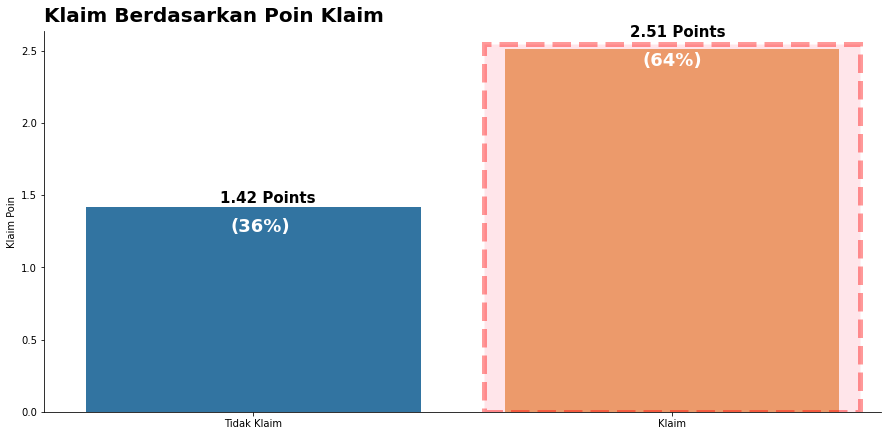

In [18]:
# Barplot
fig,ax = plt.subplots(1,figsize=(15,7))
#plt.title('Claim Points VS Claim Flag', fontweight='bold')
sns.barplot(x='CLAIM_FLAG',y='MVR_PTS', data=data_omv)

plt.ylabel('Klaim Poin')
plt.xlabel('')

# Add the rectangle
rect = Rectangle( (0.55,0), 0.9, 2.55, linestyle = 'dashed', ec='red',
                 facecolor ='pink' ,alpha=0.4 , lw=5, clip_on=True, fill=1)
ax.add_patch(rect)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#show text
plt.text(-0.08,1.45,s='1.42 Points', fontweight='bold',fontsize=15)
plt.text(-0.055,1.25,s='(36%)', fontweight='bold',fontsize=18,color='white')
plt.text(0.9,2.6,s='2.51 Points', fontweight='bold',fontsize=15)
plt.text(0.93,2.4,s='(64%)', fontweight='bold',fontsize=18,color='white')

plt.text(x=-0.5,y=2.7, s='Klaim Berdasarkan Poin Klaim', fontweight='bold',
         fontsize=20, ha='left')
#plt.text(x=-0.5,y=2.7, s='Rata-rata nominal claim points customer yang melakukan \n\
#claim memiliki nilai yang lebih besar apabila dibandingkan\n dengan yang \
#tidak melakukan claim.\
#', ha='left', color='black',fontsize=12);

ax.set_xticklabels(['Tidak Klaim','Klaim'])

plt.show();

>Insight

Customer yang melakukan claim memiliki rata-rata nilai MVR_pts sebesar 2.51 atau 77% lebih besar dari rata-rata customer yang tidak melakukan claim

## Car Type & Current Claim

In [19]:
# Creating pivot table to quantify customer based on car_type
data_ctype = pd.pivot_table(
    data,
    index   = ['CAR_TYPE'],
    values  = 'ID',
    columns = 'CLAIM_FLAG',
    aggfunc = {'ID':'count'}
).reset_index()

data_ctype.columns = ['CAR_TYPE','CLAIM_NO','CLAIM_YES']

data_ctype['Total'] = data_ctype['CLAIM_YES'] + data_ctype['CLAIM_NO']
data_ctype['CLAIM_YES_%'] = data_ctype['CLAIM_YES']/data_ctype['Total']*100
data_ctype['CLAIM_NO_%'] = data_ctype['CLAIM_NO']/data_ctype['Total']*100
data_ctype['DIFFERENCE_%'] = \
(data_ctype['CLAIM_NO'] - data_ctype['CLAIM_YES'])/data_ctype['Total']*100


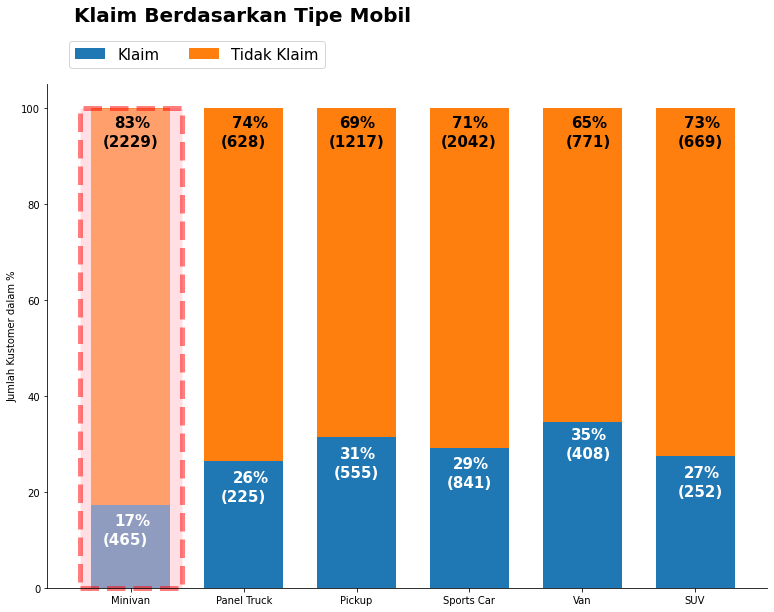

<Figure size 432x288 with 0 Axes>

In [20]:
#Plot Bar Plot in %
claim_no = np.array(data_ctype['CLAIM_NO_%'])
claim_yes = np.array(data_ctype['CLAIM_YES_%'])
fig,ax = plt.subplots(figsize=(10,7))
labels = ['Minivan','Panel Truck','Pickup','Sports Car','Van','SUV']
ax = fig.add_axes([0,0,1,1])
#ax.set_title('Claim Flag Based on Car Type in Percentage', fontweight='bold', 
             #fontsize=16)
width=0.7
ax.bar(labels, claim_yes, width, label='Klaim')
ax.bar(labels,  claim_no, width,  bottom=claim_yes, label='Tidak Klaim')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Jumlah Kustomer dalam %')

plt.tight_layout(pad=10)
plt.legend(bbox_to_anchor=(0.02, 1.1), loc=2, ncol=2,fontsize=15)

#show text

ax.text(-0.15, 13, '17%', fontsize=15, color='white', fontweight='bold')
ax.text(0.9, 22, '26%', fontsize=15, color='white', fontweight='bold')
ax.text(1.85, 27, '31%', fontsize=15, color='white', fontweight='bold')
ax.text(2.85, 25, '29%', fontsize=15, color='white', fontweight='bold')
ax.text(3.9, 31, '35%', fontsize=15, color='white', fontweight='bold')
ax.text(4.9, 23, '27%', fontsize=15, color='white', fontweight='bold')

ax.text(-0.25, 9, '(465)', fontsize=15, color='white', fontweight='bold')
ax.text(0.8, 18, '(225)', fontsize=15, color='white', fontweight='bold')
ax.text(1.8, 23, '(555)', fontsize=15, color='white', fontweight='bold')
ax.text(2.8, 21, '(841)', fontsize=15, color='white', fontweight='bold')
ax.text(3.85, 27, '(408)', fontsize=15, color='white', fontweight='bold')
ax.text(4.85, 19, '(252)', fontsize=15, color='white', fontweight='bold')


ax.text(-0.15, 96, '83%', fontsize=15, color='black', fontweight='bold')
ax.text(0.9, 96, '74%', fontsize=15, color='black', fontweight='bold')
ax.text(1.85, 96, '69%', fontsize=15, color='black', fontweight='bold')
ax.text(2.85, 96, '71%', fontsize=15, color='black', fontweight='bold')
ax.text(3.9, 96, '65%', fontsize=15, color='black', fontweight='bold')
ax.text(4.9, 96, '73%', fontsize=15, color='black', fontweight='bold')

ax.text(-0.25, 92, '(2229)', fontsize=15, color='black', fontweight='bold')
ax.text(0.8, 92, '(628)', fontsize=15, color='black', fontweight='bold')
ax.text(1.75, 92, '(1217)', fontsize=15, color='black', fontweight='bold')
ax.text(2.75, 92, '(2042)', fontsize=15, color='black', fontweight='bold')
ax.text(3.85, 92, '(771)', fontsize=15, color='black', fontweight='bold')
ax.text(4.85, 92, '(669)', fontsize=15, color='black', fontweight='bold')


plt.text(x=-0.5,y=118, s='Klaim Berdasarkan Tipe Mobil', fontweight='bold',
         fontsize=20, ha='left')
#plt.text(x=-0.5,y=105, s='Sekitar 83% pemilik kendaraan Minivan yang tidak\
#melakukan claim\n yang diikuti oleh pemilik kendaraan Panel Truck dan SUV, akan \
#tetapi \nkendaraan jenis Minivan memiliki nilai persentase "No Claim" terbesar.\
#', ha='left', color='black',fontsize=12);

# Add the rectangle
rect = Rectangle( (-0.45,0), 0.9, 100, linestyle = 'dashed', ec='red', 
                 facecolor = 'pink', alpha=0.5, lw=5, clip_on=False, fill=1)
ax.add_patch(rect)


plt.show();

plt.savefig('car type');

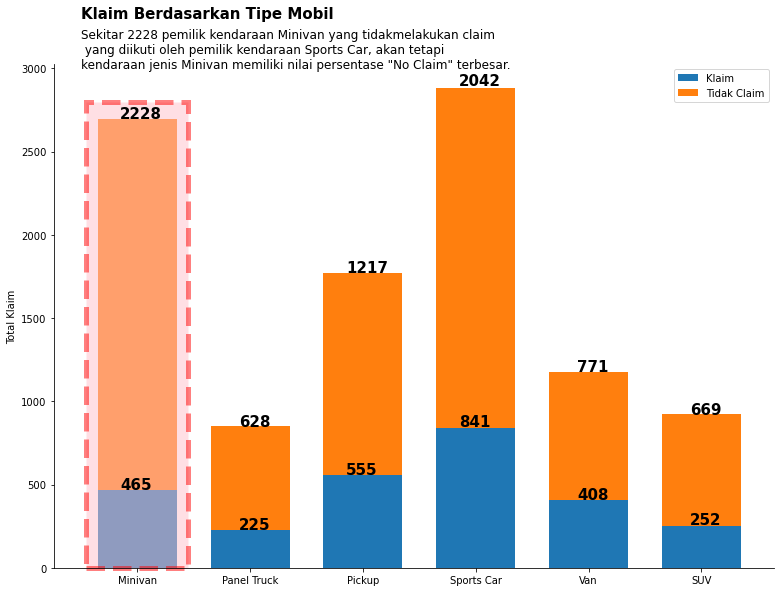

In [21]:
#Plot Bar Plot not in %
claim_no = np.array(data_ctype.CLAIM_NO)
claim_yes = np.array(data_ctype.CLAIM_YES)

fig,ax = plt.subplots(figsize=(10,7))
labels = ['Minivan','Panel Truck','Pickup','Sports Car','Van','SUV']
ax = fig.add_axes([0,0,1,1])
#ax.set_title('Claim Flag Based on Car Type',loc='left' ,fontweight='bold', fontsize=16)
width=0.7
ax.bar(labels, claim_yes, width, label='Klaim')
ax.bar(labels,  claim_no, width,  bottom=claim_yes, label='Tidak Claim')

ax.set_ylabel('Total Klaim')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#show text
ax.text(-0.15, 470, '465', fontsize=15, fontweight='bold')
ax.text(0.9, 230, '225', fontsize=15, fontweight='bold')
ax.text(1.85, 560, '555', fontsize=15, fontweight='bold')
ax.text(2.85, 850, '841', fontsize=15, fontweight='bold')
ax.text(3.9, 415, '408', fontsize=15, fontweight='bold')
ax.text(4.9, 260, '252', fontsize=15, fontweight='bold')

ax.text(-0.15, 2700, '2228', fontsize=15, fontweight='bold')
ax.text(0.9, 850, '628', fontsize=15, fontweight='bold')
ax.text(1.85, 1775, '1217', fontsize=15, fontweight='bold')
ax.text(2.85, 2900, '2042', fontsize=15, fontweight='bold')
ax.text(3.9, 1180, '771', fontsize=15, fontweight='bold')
ax.text(4.9, 925, '669', fontsize=15, fontweight='bold')

plt.text(x=-0.5,y=3300, s='Klaim Berdasarkan Tipe Mobil', fontweight='bold',
         fontsize=15, ha='left')
plt.text(x=-0.5,y=3000, s='Sekitar 2228 pemilik kendaraan Minivan yang tidak\
melakukan claim\n yang diikuti oleh pemilik kendaraan Sports Car, akan \
tetapi \nkendaraan jenis Minivan memiliki nilai persentase "No Claim" terbesar.\
', ha='left', color='black',fontsize=12);

# Add the rectangle
rect = Rectangle( (-0.45,0), 0.9, 2800, linestyle = 'dashed', ec='red', 
                 facecolor = 'pink', alpha=0.5, lw=5, clip_on=False, fill=1)
ax.add_patch(rect)

#plt.tight_layout(pad=5)
ax.legend()

plt.show();

>Insight
---
Jenis kendaraan yang memiliki persentase klaim yang rendah ialah minivan diikuti oleh jenis kendaraan panel truck dan SUV. Akan tetapi dari segi jumlah keseluruhan, jumlah minivan lebih besar. Maka dari itu, perusahaan dapat melakukan pendekatan/approach yang lebih rinci terhadap yang pemilik kendaraan jenis minivan. 


## Claim Freq & Current Claim

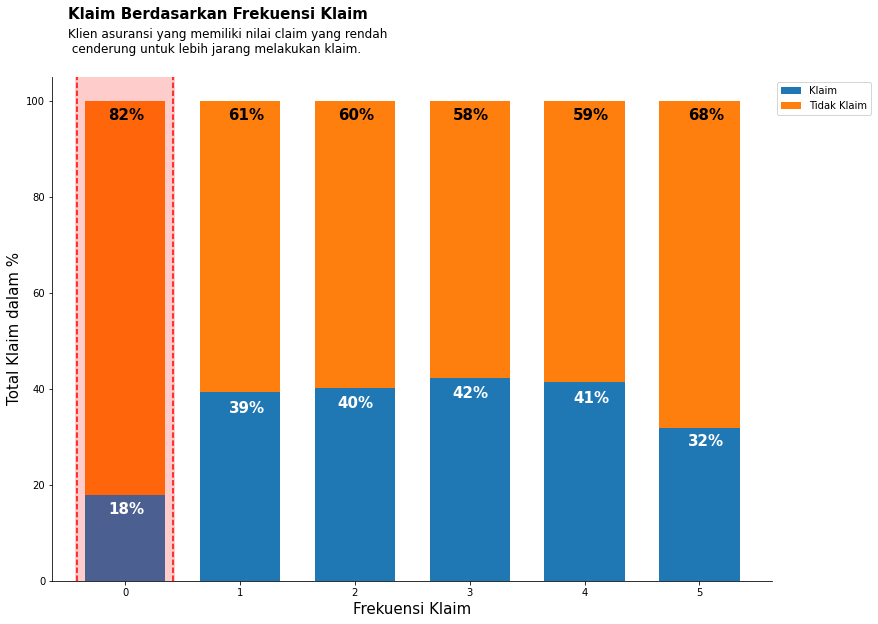

In [22]:
#Claim Freq insight

#Create pivot table
data_clfreq = pd.pivot_table(data,
                             values='ID',
                             aggfunc='count',
                             index ='CLM_FREQ',
                             columns='CLAIM_FLAG').reset_index()

data_clfreq.columns = ['claim freq','CLAIM_NO','CLAIM_YES']

data_clfreq['Total'] = data_clfreq['CLAIM_YES'] + data_clfreq['CLAIM_NO']
data_clfreq['CLAIM_YES_%'] = data_clfreq['CLAIM_YES']/data_clfreq['Total']*100
data_clfreq['CLAIM_NO_%'] = data_clfreq['CLAIM_NO']/data_clfreq['Total']*100
data_clfreq['DIFFERENCE_%'] = \
(data_clfreq['CLAIM_NO'] - data_clfreq['CLAIM_YES'])/data_clfreq['Total']*100


#Plot Bar Plot in %
claim_no = np.array(data_clfreq['CLAIM_NO_%'])
claim_yes = np.array(data_clfreq['CLAIM_YES_%'])
fig,ax = plt.subplots(figsize=(10,7))
labels = [0,1,2,3,4,5]
ax = fig.add_axes([0,0,1,1])
#ax.set_title('Claim Flag Based on Claim Frequency', fontweight='bold', fontsize=16)
width=0.7
ax.bar(labels, claim_yes, width, label='Klaim')
ax.bar(labels,  claim_no, width,  bottom=claim_yes, label='Tidak Klaim')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Total Klaim dalam %',fontsize=15)
ax.set_xlabel('Frekuensi Klaim',fontsize=15)

ax.legend(loc='best', bbox_to_anchor=(1,1))

plt.axvline(x=0.42, linestyle='dashed', color='red');
plt.axvline(x=-0.42,linestyle='dashed', color = 'red');
plt.axvline(x=0, linewidth=100, color='red', alpha=0.2);

#show text

ax.text(-0.15, 14, '18%', fontsize=15, color='white', fontweight='bold')
ax.text(0.9, 35, '39%', fontsize=15, color='white', fontweight='bold')
ax.text(1.85, 36, '40%', fontsize=15, color='white', fontweight='bold')
ax.text(2.85, 38, '42%', fontsize=15, color='white', fontweight='bold')
ax.text(3.9, 37, '41%', fontsize=15, color='white', fontweight='bold')
ax.text(4.9, 28, '32%', fontsize=15, color='white', fontweight='bold')

ax.text(-0.15, 96, '82%', fontsize=15, color='black', fontweight='bold')
ax.text(0.9, 96, '61%', fontsize=15, color='black', fontweight='bold')
ax.text(1.85, 96, '60%', fontsize=15, color='black', fontweight='bold')
ax.text(2.85, 96, '58%', fontsize=15, color='black', fontweight='bold')
ax.text(3.9, 96, '59%', fontsize=15, color='black', fontweight='bold')
ax.text(4.9, 96, '68%', fontsize=15, color='black', fontweight='bold')

plt.text(x=-0.5,y=117, s='Klaim Berdasarkan Frekuensi Klaim', fontweight='bold',
         fontsize=15, ha='left')
plt.text(x=-0.5,y=110, s='Klien asuransi yang memiliki nilai claim yang rendah\n\
 cenderung untuk lebih jarang melakukan klaim.\
', ha='left', color='black',fontsize=12);

plt.savefig('fequency');

Text(2.85, 997, '572')

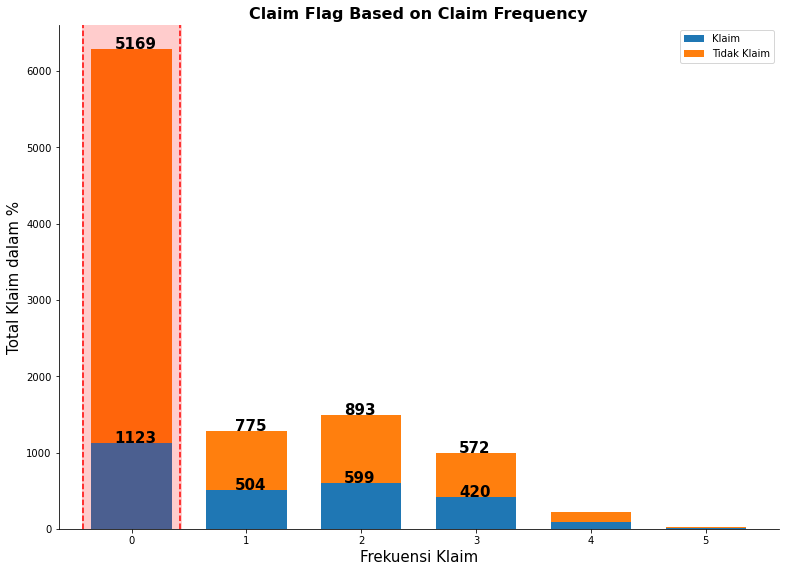

In [23]:
#Plot Bar Plot in total
claim_no = np.array(data_clfreq['CLAIM_NO'])
claim_yes = np.array(data_clfreq['CLAIM_YES'])
fig,ax = plt.subplots(figsize=(10,7))
labels = [0,1,2,3,4,5]
ax = fig.add_axes([0,0,1,1])
ax.set_title('Claim Flag Based on Claim Frequency', fontweight='bold', fontsize=16)
width=0.7
ax.bar(labels, claim_yes, width, label='Klaim')
ax.bar(labels,  claim_no, width,  bottom=claim_yes, label='Tidak Klaim')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Total Klaim dalam %',fontsize=15)
ax.set_xlabel('Frekuensi Klaim',fontsize=15)

ax.legend(loc='best')

plt.axvline(x=0.42, linestyle='dashed', color='red');
plt.axvline(x=-0.42,linestyle='dashed', color = 'red');
plt.axvline(x=0, linewidth=100, color='red', alpha=0.2);

#show text
ax.text(-0.15, 1128, '1123', fontsize=15, fontweight='bold')
ax.text(0.9, 509, '504', fontsize=15, fontweight='bold')
ax.text(1.85, 604, '599', fontsize=15, fontweight='bold')
ax.text(2.85, 425, '420', fontsize=15, fontweight='bold')
#ax.text(3.9, 98, '93', fontsize=15, fontweight='bold')
#ax.text(4.9, 12, '7', fontsize=15, fontweight='bold')

ax.text(-0.15, 6297, '5169', fontsize=15, fontweight='bold')
ax.text(0.9, 1284, '775', fontsize=15, fontweight='bold')
ax.text(1.85, 1497, '893', fontsize=15, fontweight='bold')
ax.text(2.85, 997, '572', fontsize=15, fontweight='bold')
#ax.text(3.9, 230, '132', fontsize=15, fontweight='bold')
#ax.text(4.9, 27, '15', fontsize=15, fontweight='bold')

## Cat Claim Freq & Current Claim

,ID,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,...,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG
0,63581743,0,60.0,0,11.0,67349.0,False,0.0,False,M,...,11,Minivan,True,4461.0,2,False,3,0.0,18.0,False
1,132761049,0,43.0,0,11.0,91449.0,False,257252.0,False,M,...,1,Minivan,True,0.0,0,False,0,0.0,1.0,False
2,921317019,0,48.0,0,11.0,52881.0,False,0.0,False,M,...,1,Van,True,0.0,0,False,2,0.0,10.0,False
3,727598473,0,35.0,1,10.0,16039.0,False,124191.0,True,F,...,4,SUV,False,38690.0,2,False,3,0.0,10.0,False
4,450221861,0,51.0,0,14.0,NaN,False,306251.0,True,M,...,7,Minivan,True,0.0,0,False,0,0.0,6.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,67790126,1,45.0,2,9.0,164669.0,False,386273.0,True,M,...,15,Minivan,False,0.0,0,False,2,0.0,17.0,False
10298,61970712,0,46.0,0,9.0,107204.0,False,332591.0,True,M,...,6,Panel Truck,False,0.0,0,False,0,0.0,1.0,False
10299,849208064,0,48.0,0,15.0,39837.0,False,170611.0,True,F,...,7,SUV,False,0.0,0,False,0,0.0,1.0,False
10300,627828331,0,50.0,0,7.0,43445.0,False,149248.0,True,F,...,6,Minivan,False,0.0,0,False,0,0.0,11.0,False


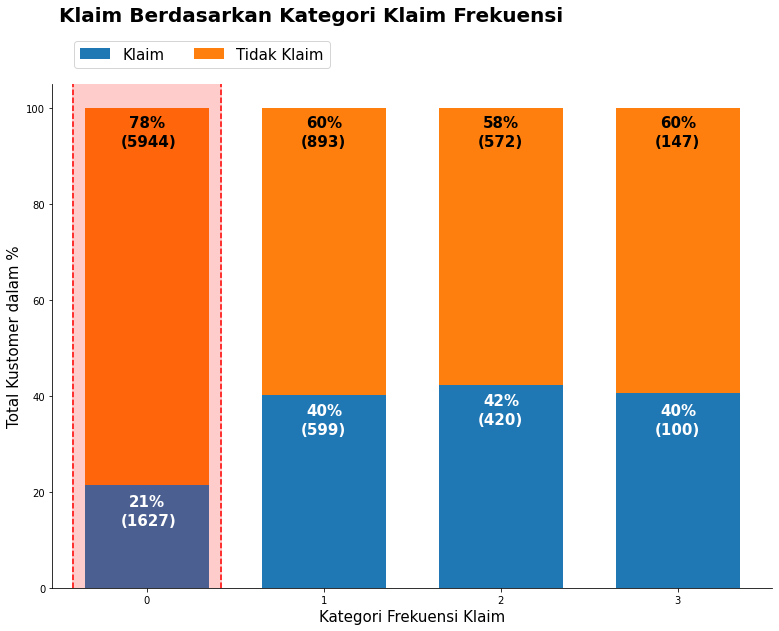

In [24]:
#Cat Claim Freq insight
#feature engineering
category = np.nanquantile(data['CLM_FREQ'], q=[0, 0.7, 0.8, 0.9, 1])
data['cat_CLM_FREQ'] = pd.cut(data['CLM_FREQ'], bins=category, 
                       labels=False, include_lowest=True)


#Create pivot table
data_catfreq = pd.pivot_table(data,
                             values='ID',
                             aggfunc='count',
                             index ='cat_CLM_FREQ',
                             columns='CLAIM_FLAG').reset_index()

data_catfreq.columns = ['cat claim freq','CLAIM_NO','CLAIM_YES']

data_catfreq['Total'] = data_catfreq['CLAIM_YES'] + data_catfreq['CLAIM_NO']
data_catfreq['CLAIM_YES_%'] = data_catfreq['CLAIM_YES']/data_catfreq['Total']*100
data_catfreq['CLAIM_NO_%'] = data_catfreq['CLAIM_NO']/data_catfreq['Total']*100
data_catfreq['DIFFERENCE_%'] = \
(data_catfreq['CLAIM_NO'] - data_catfreq['CLAIM_YES'])/data_catfreq['Total']*100


#Plot Bar Plot in %
claim_no = np.array(data_catfreq['CLAIM_NO_%'])
claim_yes = np.array(data_catfreq['CLAIM_YES_%'])
fig,ax = plt.subplots(figsize=(10,7))
labels = [0,1,2,3]
ax = fig.add_axes([0,0,1,1])
#ax.set_title('Claim Flag Based on Claim Frequency', fontweight='bold', fontsize=16)
width=0.7
ax.bar(labels, claim_yes, width, label='Klaim')
ax.bar(labels,  claim_no, width,  bottom=claim_yes, label='Tidak Klaim')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Total Kustomer dalam %',fontsize=15)
ax.set_xlabel('Kategori Frekuensi Klaim',fontsize=15)
plt.xticks(np.arange(4), [0,1,2,3])

plt.legend(bbox_to_anchor=(0.02, 1.1), loc=2, ncol=2,fontsize=15)

plt.axvline(x=0.42, linestyle='dashed', color='red');
plt.axvline(x=-0.42,linestyle='dashed', color = 'red');
plt.axvline(x=0, linewidth=150, color='red', alpha=0.2);

#show text

ax.text(-0.1, 17, '21%', fontsize=15, color='white', fontweight='bold')
ax.text(0.9, 36, '40%', fontsize=15, color='white', fontweight='bold')
ax.text(1.9, 38, '42%', fontsize=15, color='white', fontweight='bold')
ax.text(2.9, 36, '40%', fontsize=15, color='white', fontweight='bold')

ax.text(-0.15, 13, '(1627)', fontsize=15, color='white', fontweight='bold')
ax.text(0.87, 32, '(599)', fontsize=15, color='white', fontweight='bold')
ax.text(1.87, 34, '(420)', fontsize=15, color='white', fontweight='bold')
ax.text(2.87, 32, '(100)', fontsize=15, color='white', fontweight='bold')


ax.text(-0.1, 96, '78%', fontsize=15, color='black', fontweight='bold')
ax.text(0.9, 96, '60%', fontsize=15, color='black', fontweight='bold')
ax.text(1.9, 96, '58%', fontsize=15, color='black', fontweight='bold')
ax.text(2.9, 96, '60%', fontsize=15, color='black', fontweight='bold')

ax.text(-0.15, 92, '(5944)', fontsize=15, color='black', fontweight='bold')
ax.text(0.87, 92, '(893)', fontsize=15, color='black', fontweight='bold')
ax.text(1.87, 92, '(572)', fontsize=15, color='black', fontweight='bold')
ax.text(2.87, 92, '(147)', fontsize=15, color='black', fontweight='bold')


plt.text(x=-0.5,y=118, s='Klaim Berdasarkan Kategori Klaim Frekuensi', fontweight='bold',
         fontsize=20, ha='left')
#plt.text(x=-0.5,y=110, s='Klien asuransi yang memiliki nilai claim yang rendah\n\
#cenderung untuk lebih jarang melakukan klaim.\
#', ha='left', color='black',fontsize=12);

plt.savefig('fequency');

data.drop(['cat_CLM_FREQ'], axis=1)

## KIDSDRIV & Current Claim

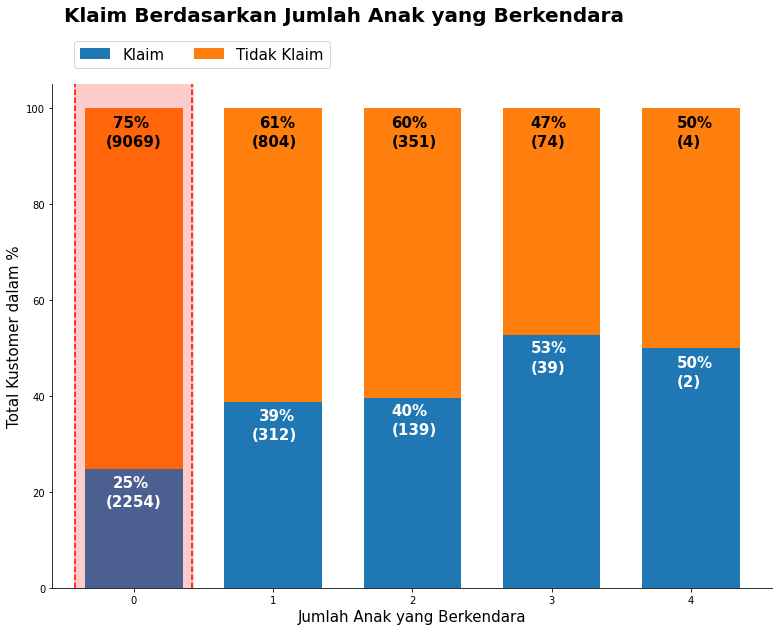

In [25]:
#Claim Freq insight

#Create pivot table
data_kidsdriv = pd.pivot_table(data,
                             values='ID',
                             aggfunc='count',
                             index ='KIDSDRIV',
                             columns='CLAIM_FLAG').reset_index()

data_kidsdriv.columns = ['kidsdriv','CLAIM_NO','CLAIM_YES']

data_kidsdriv['Total'] = data_kidsdriv['CLAIM_YES'] + data_kidsdriv['CLAIM_NO']
data_kidsdriv['CLAIM_YES_%'] = data_kidsdriv['CLAIM_YES']/data_kidsdriv['Total']*100
data_kidsdriv['CLAIM_NO_%'] = data_kidsdriv['CLAIM_NO']/data_kidsdriv['Total']*100
data_kidsdriv['DIFFERENCE_%'] = \
(data_kidsdriv['CLAIM_NO'] - data_kidsdriv['CLAIM_YES'])/data_kidsdriv['Total']*100


#Plot Bar Plot in %
claim_no = np.array(data_kidsdriv['CLAIM_NO_%'])
claim_yes = np.array(data_kidsdriv['CLAIM_YES_%'])
fig,ax = plt.subplots(figsize=(10,7))
labels = [0,1,2,3,4]
ax = fig.add_axes([0,0,1,1])
#ax.set_title('Claim Flag Based on Kidsdriv', fontweight='bold', 
             #fontsize=16)
width=0.7
ax.bar(labels, claim_yes, width, label='Klaim')
ax.bar(labels,  claim_no, width,  bottom=claim_yes, label='Tidak Klaim')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Total Kustomer dalam %',fontsize=15)
ax.set_xlabel('Jumlah Anak yang Berkendara',fontsize=15)

plt.legend(bbox_to_anchor=(0.02, 1.1), loc=2, ncol=2,fontsize=15)

plt.axvline(x=0.42, linestyle='dashed', color='red');
plt.axvline(x=-0.42,linestyle='dashed', color = 'red');
plt.axvline(x=0, linewidth=120, color='red', alpha=0.2);

#show text

ax.text(-0.15, 21, '25%', fontsize=15, color='white', fontweight='bold')
ax.text(0.9, 35, '39%', fontsize=15, color='white', fontweight='bold')
ax.text(1.85, 36, '40%', fontsize=15, color='white', fontweight='bold')
ax.text(2.85, 49, '53%', fontsize=15, color='white', fontweight='bold')
ax.text(3.9, 46, '50%', fontsize=15, color='white', fontweight='bold')

ax.text(-0.2, 17, '(2254)', fontsize=15, color='white', fontweight='bold')
ax.text(0.85, 31, '(312)', fontsize=15, color='white', fontweight='bold')
ax.text(1.85, 32, '(139)', fontsize=15, color='white', fontweight='bold')
ax.text(2.85, 45, '(39)', fontsize=15, color='white', fontweight='bold')
ax.text(3.9, 42, '(2)', fontsize=15, color='white', fontweight='bold')


ax.text(-0.15, 96, '75%', fontsize=15, color='black', fontweight='bold')
ax.text(0.9, 96, '61%', fontsize=15, color='black', fontweight='bold')
ax.text(1.85, 96, '60%', fontsize=15, color='black', fontweight='bold')
ax.text(2.85, 96, '47%', fontsize=15, color='black', fontweight='bold')
ax.text(3.9, 96, '50%', fontsize=15, color='black', fontweight='bold')

ax.text(-0.2, 92, '(9069)', fontsize=15, color='black', fontweight='bold')
ax.text(0.85, 92, '(804)', fontsize=15, color='black', fontweight='bold')
ax.text(1.85, 92, '(351)', fontsize=15, color='black', fontweight='bold')
ax.text(2.85, 92, '(74)', fontsize=15, color='black', fontweight='bold')
ax.text(3.9, 92, '(4)', fontsize=15, color='black', fontweight='bold')


plt.text(x=-0.5,y=118, s='Klaim Berdasarkan Jumlah Anak yang Berkendara', fontweight='bold',
         fontsize=20, ha='left')
#plt.text(x=-0.5,y=110, s='Klien asuransi yang memiliki lebih sedikit anak yang bekendara mobil \n\
# cenderung untuk lebih jarang melakukan klaim.\
#', ha='left', color='black',fontsize=12);

plt.savefig('kidsdriv');

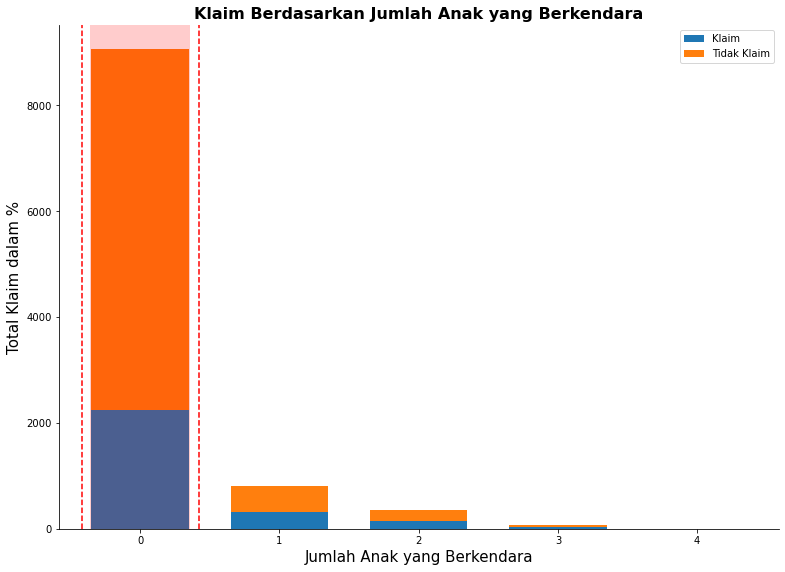

In [26]:
#Plot Bar Plot in total
claim_no = np.array(data_kidsdriv['CLAIM_NO'])
claim_yes = np.array(data_kidsdriv['CLAIM_YES'])
fig,ax = plt.subplots(figsize=(10,7))
labels = [0,1,2,3,4]
ax = fig.add_axes([0,0,1,1])
ax.set_title('Klaim Berdasarkan Jumlah Anak yang Berkendara', fontweight='bold', 
             fontsize=16)
width=0.7
ax.bar(labels, claim_yes, width, label='Klaim')
ax.bar(labels,  claim_no, width,  bottom=claim_yes, label='Tidak Klaim')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Total Klaim dalam %',fontsize=15)
ax.set_xlabel('Jumlah Anak yang Berkendara',fontsize=15)

ax.legend(loc='best', bbox_to_anchor=(1,1))

plt.axvline(x=0.42, linestyle='dashed', color='red');
plt.axvline(x=-0.42,linestyle='dashed', color = 'red');
plt.axvline(x=0, linewidth=100, color='red', alpha=0.2);

## TIF & Current Claim

In [27]:
#TIF Insight
category = np.nanquantile(data['TIF'], q=[0, 0.7, 0.8, 0.9, 1])
data['cat_TIF'] = pd.cut(data['TIF'], bins=category, 
                       labels=False, include_lowest=True)

#Create pivot table
data_tif = pd.pivot_table(data,
                             values='ID',
                             aggfunc='count',
                             index ='cat_TIF',
                             columns='CLAIM_FLAG').reset_index()

data_tif.columns = ['TIF','CLAIM_NO','CLAIM_YES']

data_tif['Total'] = data_tif['CLAIM_YES'] + data_tif['CLAIM_NO']
data_tif['CLAIM_YES_%'] = data_tif['CLAIM_YES']/data_tif['Total']*100
data_tif['CLAIM_NO_%'] = data_tif['CLAIM_NO']/data_tif['Total']*100
data_tif['DIFFERENCE_%'] = \
(data_tif['CLAIM_NO'] - data_tif['CLAIM_YES'])/data_tif['Total']*100


data_tif

,TIF,CLAIM_NO,CLAIM_YES,Total,CLAIM_YES_%,CLAIM_NO_%,DIFFERENCE_%
0,0,5667,2216,7883,28.111125,71.888875,43.777750
1,1,289,93,382,24.345550,75.654450,51.308901
2,2,984,267,1251,21.342926,78.657074,57.314149
3,3,616,170,786,21.628499,78.371501,56.743003


Text(-0.5, 117, 'Klaim Berdasarkan Lama Klien Bergabung (tahun)')

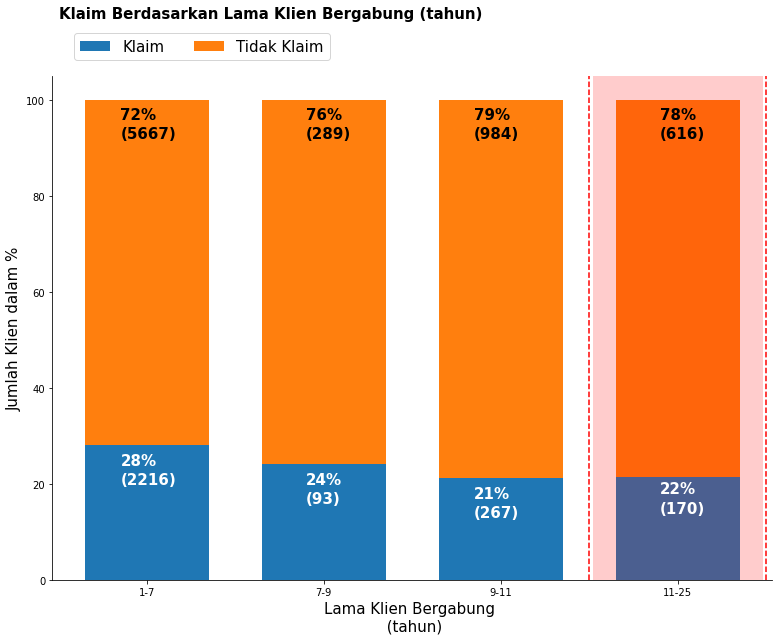

In [28]:
#Plot Bar Plot in %
claim_no = np.array(data_tif['CLAIM_NO_%'])
claim_yes = np.array(data_tif['CLAIM_YES_%'])
fig,ax = plt.subplots(figsize=(10,7))
labels = ['1-7','7-9','9-11','11-25']
ax = fig.add_axes([0,0,1,1])
#ax.set_title('Klaim Berdasarkan TIF', fontweight='bold', fontsize=16)
width=0.7
ax.bar(labels, claim_yes, width, label='Klaim')
ax.bar(labels,  claim_no, width,  bottom=claim_yes, label='Tidak Klaim')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Jumlah Klien dalam %',fontsize=15)
ax.set_xlabel('Lama Klien Bergabung \n (tahun)',fontsize=15)

plt.legend(bbox_to_anchor=(0.02, 1.1), loc=2, ncol=2,fontsize=15)

plt.axvline(x=2.5, linestyle='dashed', color='red');
plt.axvline(x=3.5,linestyle='dashed', color = 'red');
plt.axvline(x=3, linewidth=170, color='red', alpha=0.2);

#show text

ax.text(-0.15, 24, '28%', fontsize=15, color='white', fontweight='bold')
ax.text(0.9, 20, '24%', fontsize=15, color='white', fontweight='bold')
ax.text(1.85, 17, '21%', fontsize=15, color='white', fontweight='bold')
ax.text(2.9, 18, '22%', fontsize=15, color='white', fontweight='bold')

ax.text(-0.15, 20, '(2216)', fontsize=15, color='white', fontweight='bold')
ax.text(0.9, 16, '(93)', fontsize=15, color='white', fontweight='bold')
ax.text(1.85, 13, '(267)', fontsize=15, color='white', fontweight='bold')
ax.text(2.9, 14, '(170)', fontsize=15, color='white', fontweight='bold')


ax.text(-0.15, 96, '72%', fontsize=15, color='black', fontweight='bold')
ax.text(0.9, 96, '76%', fontsize=15, color='black', fontweight='bold')
ax.text(1.85, 96, '79%', fontsize=15, color='black', fontweight='bold')
ax.text(2.9, 96, '78%', fontsize=15, color='black', fontweight='bold')

ax.text(-0.15, 92, '(5667)', fontsize=15, color='black', fontweight='bold')
ax.text(0.9, 92, '(289)', fontsize=15, color='black', fontweight='bold')
ax.text(1.85, 92, '(984)', fontsize=15, color='black', fontweight='bold')
ax.text(2.9, 92, '(616)', fontsize=15, color='black', fontweight='bold')


plt.text(x=-0.5,y=117, s='Klaim Berdasarkan Lama Klien Bergabung (tahun)', fontweight='bold',
         fontsize=15, ha='left')
#plt.text(x=-0.5,y=110, s='Klien asuransi yang memiliki nilai claim yang rendah\n\
# .\
#', ha='left', color='black',fontsize=12);

## Occupation & Current Claim

<AxesSubplot:xlabel='OCCUPATION', ylabel='no_claim'>

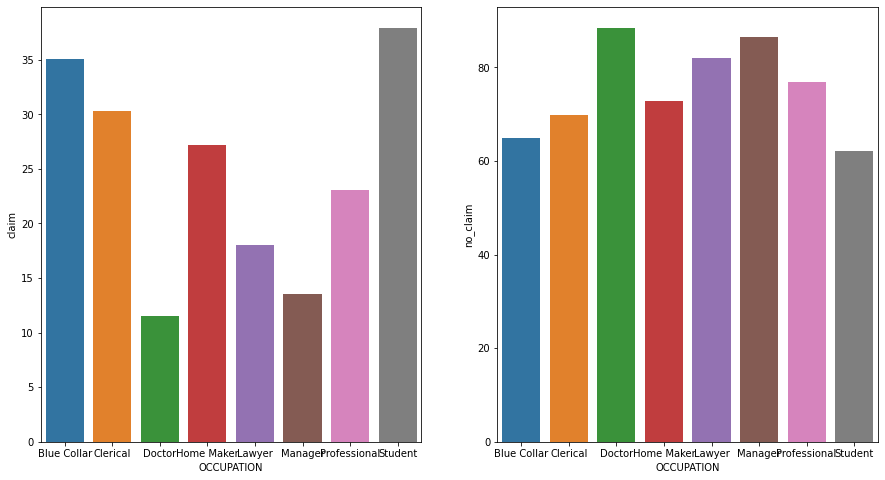

In [29]:
cat_pivot = pd.pivot_table(
    data, values="ID", columns="CLAIM_FLAG", index=["OCCUPATION"],aggfunc="count"
).reset_index()

cat_pivot["total"] = cat_pivot[[0, 1]].apply(sum, axis=1)

cat_pivot["no_claim"] = cat_pivot[0] / cat_pivot.total * 100
cat_pivot["claim"]    = cat_pivot[1] / cat_pivot.total * 100

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.barplot(x="OCCUPATION", y="claim", data=cat_pivot, ax=ax[0])
sns.barplot(x="OCCUPATION", y="no_claim", data=cat_pivot, ax=ax[1])

## Single Parent & Driving Kids

In [30]:
parent_kid = pd.pivot_table(
    data,
    values='ID',
    columns='CLAIM_FLAG',
    index=['KIDSDRIV', 'PARENT1'],
    aggfunc='count'
).reset_index()
parent_kid['total'] = parent_kid[0]+parent_kid[1]
parent_kid['percentage'] = parent_kid[1]/parent_kid['total']*100

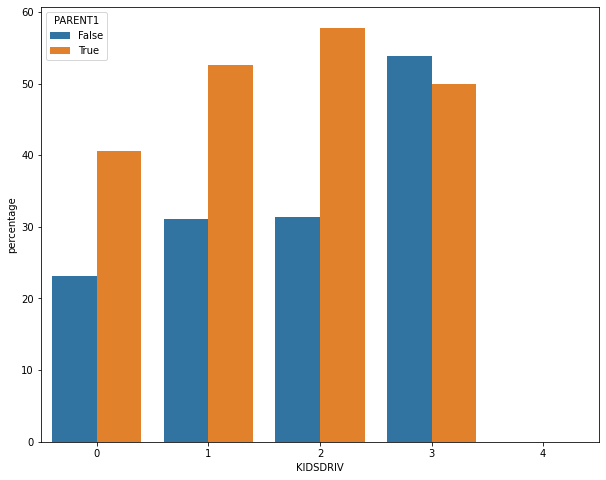

In [31]:
#barplot
plt.figure(figsize=(10,8))
sns.barplot(x='KIDSDRIV', y='percentage',hue='PARENT1', data=parent_kid);


Dari populasi customer yang single parent, paling banyak disetujui claimnya adalah yang kidsdriv = 2, pada populasi yang tidak single parent, klaim paling banyak disetujui pada kidsdriv = 3.

## Marital Status & Current Claim

In [32]:
data['MSTATUS'].replace('z_No','No',inplace=True)
marital_claim = data.groupby(['MSTATUS','CLAIM_FLAG']).agg({'ID':['count']}).reset_index()
marital_claim.columns=['MSTATUS','CLAIM FLAG', 'TOTAL CUSTOMER']

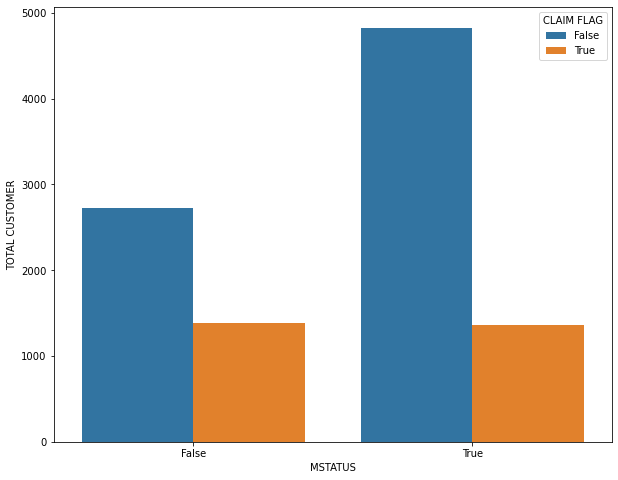

In [33]:
plt.figure(figsize=(10,8))
sns.barplot(x='MSTATUS', y='TOTAL CUSTOMER', hue='CLAIM FLAG', data=marital_claim);

Kebanyakan claim yg disetujui adalah customer yang sudah menikah

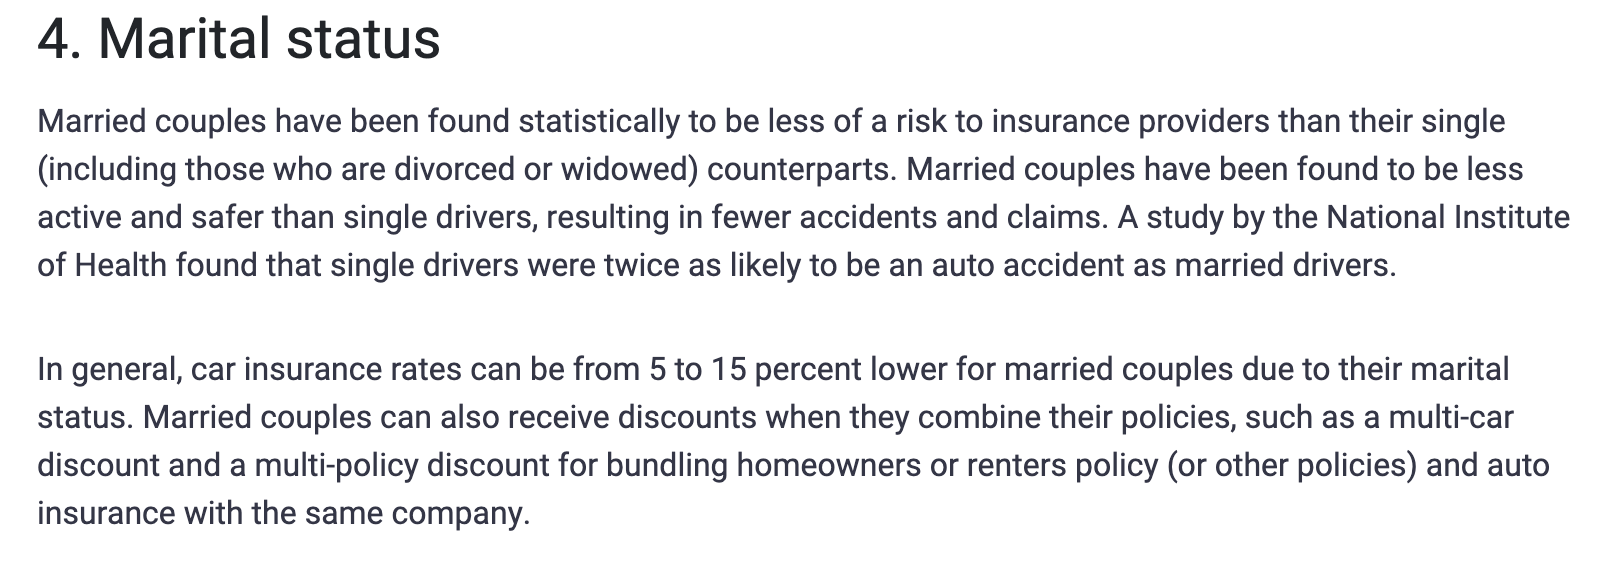

sumber artikel https://www.insure.com/car-insurance/car-insurance-factors.html#married

## Red Car, Revoked License & Current Claim

Insight 1

In [34]:
data['CAR_AGE_GROUP'] = pd.cut(
    data.CAR_AGE, bins = [0,5,10,30], labels = [0,1,2]
)

In [35]:
car_age_claim = data.groupby(['CLAIM_FLAG','CAR_AGE_GROUP']).agg(
    {'ID':['count']}
).reset_index()

In [36]:
car_age_claim.columns=['CLAIM FLAG','CAR AGE GROUP','TOTAL CUSTOMER']

In [37]:
car_age_claim['PERCENTAGE']=(car_age_claim['TOTAL CUSTOMER']/(car_age_claim['TOTAL CUSTOMER'].sum()))*100

In [38]:
car_age_claim['CLAIM FLAG'].replace(False,'No',inplace=True)
car_age_claim['CLAIM FLAG'].replace(True,'Yes',inplace=True)
car_age_claim['CAR AGE GROUP'].replace(0,'Young',inplace=True)
car_age_claim['CAR AGE GROUP'].replace(1,'Middle',inplace=True)
car_age_claim['CAR AGE GROUP'].replace(2,'Old',inplace=True)

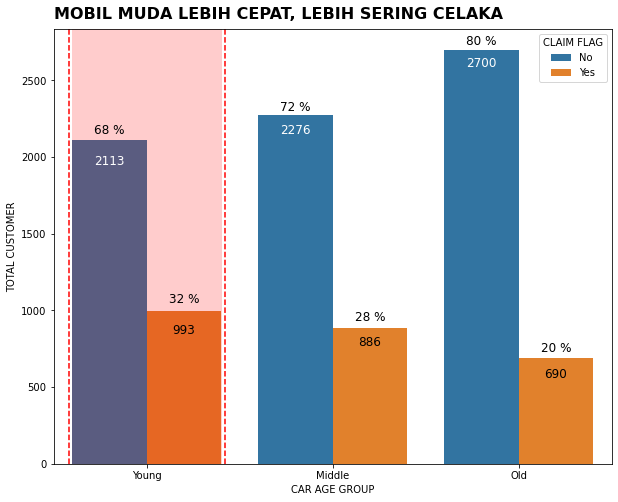

In [39]:
plt.figure(figsize=(10,8))
sns.barplot(x='CAR AGE GROUP', y='TOTAL CUSTOMER',hue='CLAIM FLAG', data=car_age_claim);
plt.axvline(x=0.42, linestyle='dashed', color='red');
plt.axvline(x=-0.42,linestyle='dashed', color = 'red');
plt.axvline(x=0, linewidth=150, color='red', alpha=0.2);

# plt.text(x=0.2,y=11, s='10.28 %', ha='center', color='black',fontsize=12);
# plt.text(x=-0.2,y=22.7, s='21.87 %', ha='center', color='black',fontsize=12);
# plt.text(x=1.2,y=10, s='9.17 %', ha='center', color='black',fontsize=12);
# plt.text(x=0.8,y=24, s='23.56 %', ha='center', color='black',fontsize=12);
# plt.text(x=2.2,y=8, s='7.14 %', ha='center', color='black',fontsize=12);
# plt.text(x=1.8,y=28.3, s='27.95 %', ha='center', color='black',fontsize=12);


# plt.text(x=-0.5,y=33.5, s='MOBIL MUDA LEBIH CEPAT, LEBIH SERING CELAKA', weight='bold',ha='left', color='black',fontsize=16);
# plt.text(x=-0.5,y=30.3, s='Sekitar 10.28 % customer yang memiliki mobil usia muda melakukan claim,\nmengingat kondisi mobil yang masih prima customer tersebut cenderung\nmengendarai mobil nya lebih cepat sehingga tingkat kecelakaan meningkat.', ha='left', color='black',fontsize=12);

plt.text(x=0.2,y=1050, s='32 %', ha='center', color='black',fontsize=12);
plt.text(x=-0.2,y=2150, s='68 %', ha='center', color='black',fontsize=12);
plt.text(x=1.2,y=930, s='28 %', ha='center', color='black',fontsize=12);
plt.text(x=0.8,y=2300, s='72 %', ha='center', color='black',fontsize=12);
plt.text(x=2.2,y=730, s='20 %', ha='center', color='black',fontsize=12);
plt.text(x=1.8,y=2730, s='80 %', ha='center', color='black',fontsize=12);


plt.text(x=0.2,y=850, s='993', ha='center', color='black',fontsize=12);
plt.text(x=-0.2,y=1950, s='2113', ha='center', color='white',fontsize=12);
plt.text(x=1.2,y=770, s='886', ha='center', color='black',fontsize=12);
plt.text(x=0.8,y=2150, s='2276', ha='center', color='white',fontsize=12);
plt.text(x=2.2,y=560, s='690', ha='center', color='black',fontsize=12);
plt.text(x=1.8,y=2590, s='2700', ha='center', color='white',fontsize=12);


plt.text(x=-0.5,y=2900, s='MOBIL MUDA LEBIH CEPAT, LEBIH SERING CELAKA', weight='bold',ha='left', color='black',fontsize=16);

Dari plot diatas dapat dilihat bahwa jumlah mobil yang paling banyak dimiliki customer ada pada golongan old, dan yang paling sedikit adalah golongan young, tingkat claim paling tinggi ada pada golongan young dan terendah ada pada golongan old. Kami berasumsi mobil yang memiliki usia muda memiliki kondisi yang masih prima sehingga pengemudi cenderung meningkatkan kecepatan dalam berkendara jadi memiliki tingkat kecelakaan yang lebih tinggi, sedangkan mobil yang sudah tua cenderung di kemudikan dengan kecepatan yang lebih lambat karena kondisi mesin yang sudah tidak prima lagi sehingga potensi kecelakaan nya lebih rendah.

Insight 2

In [40]:
redcar_claim = data.groupby(
    ['RED_CAR','CLAIM_FLAG']
).agg({'ID':['count']}).reset_index()

redcar_claim.columns=['RED CAR','CLAIM FLAG','TOTAL CUSTOMER']
redcar_claim['RED CAR'].replace(False,'Not Red',inplace=True)
redcar_claim['RED CAR'].replace(True,'Red',inplace=True)
redcar_claim['CLAIM FLAG'].replace(False,'No',inplace=True)
redcar_claim['CLAIM FLAG'].replace(True,'Yes',inplace=True)

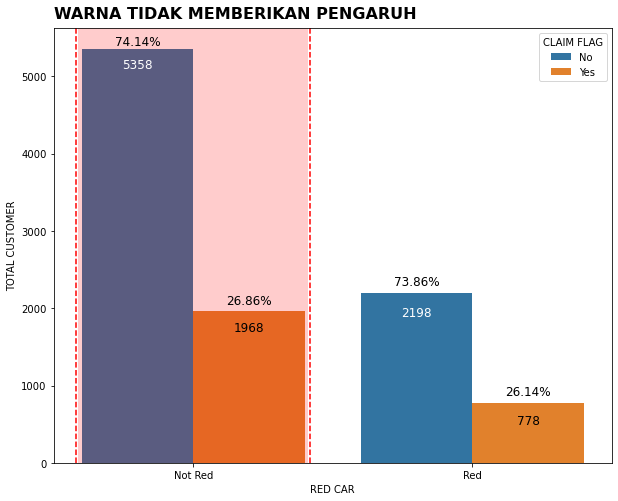

In [41]:
plt.figure(figsize=(10,8))
sns.barplot(x='RED CAR', y='TOTAL CUSTOMER',hue='CLAIM FLAG', data=redcar_claim);

plt.axvline(x=0.42, linestyle='dashed', color='red');
plt.axvline(x=-0.42,linestyle='dashed', color = 'red');
plt.axvline(x=0, linewidth=230, color='red', alpha=0.2);


# # plt.text(x=revoked_claim['REVOKED'][0],x=0, y=6900, s='6864', ha='center', color='black',fontsize=12);
# plt.text(x=0.2,y=2100, s='26.86%', ha='center', color='black',fontsize=12);
# plt.text(x=1.2,y=880, s='26.14%', ha='center', color='black',fontsize=12);
# # plt.text(x=revoked_claim['PaymentMethod'][2],y=77, s='76', ha='center', color='black',fontsize=12);
# # plt.text(x=revoked_claim['PaymentMethod'][3],y=45, s='44', ha='center', color='black',fontsize=12);

# plt.text(x=-0.5,y=6650, s='WARNA TIDAK MEMBERIKAN PENGARUH', weight='bold',ha='left', color='black',fontsize=16);
# plt.text(x=-0.5,y=5800, s='Baik customer yang memiliki mobil berwarna merah ataupun warna lain memiliki presentasi\nclaim yang cenderung sama yaitu sekitar 26 %. Yang menjadi pembeda adalah harga cat\nmobil merah memiliki harga cat yang lebih mahal dibanding warna lainnya\nsehingga cenderung menimbulkan biaya perbaikan yang lebih tinggi', ha='left', color='black',fontsize=12);

plt.text(x=0.2,y=2050, s='26.86%', ha='center', color='black',fontsize=12);
plt.text(x=1.2,y=880, s='26.14%', ha='center', color='black',fontsize=12);
plt.text(x=-0.2,y=5400, s='74.14%', ha='center', color='black',fontsize=12);
plt.text(x=0.2,y=1700, s='1968', ha='center', color='black',fontsize=12);
plt.text(x=-0.2,y=5100, s='5358', ha='center', color='white',fontsize=12);
plt.text(x=0.8,y=1900, s='2198', ha='center', color='white',fontsize=12);
plt.text(x=1.2,y=500, s='778', ha='center', color='black',fontsize=12);
plt.text(x=0.8,y=2300, s='73.86%', ha='center', color='black',fontsize=12);

plt.text(x=-0.5,y=5750, s='WARNA TIDAK MEMBERIKAN PENGARUH', weight='bold',ha='left', color='black',fontsize=16);

Dari plot diatas dapat dilihat customer lebih banyak yang memiliki mobil tidak berwarna merah, dan presentasi calim antara customer yang memiliki mobil berwana merah ataupun warna lainnya cenderung sama yaitu sekitar 26%. Yang menjadi pembeda adalah harga cat mobil berwarna merah lebih mahal dari cat mobil warna lainnya.

Cat mobil berwarna merah lebih mahal dai warna lainnya https://asnusantara.co.id/?p=1117

Insight 3

In [42]:
revoked_claim = data.groupby(
    ['REVOKED','CLAIM_FLAG']
).agg({'ID':['count']}).reset_index()

revoked_claim.CLAIM_FLAG = revoked_claim.CLAIM_FLAG.astype("object")
revoked_claim.REVOKED = revoked_claim.REVOKED.astype("object")

revoked_claim.columns=['REVOKED','CLAIM FLAG','TOTAL CUSTOMER']
revoked_claim['REVOKED'].replace(False,'No',inplace=True)
revoked_claim['REVOKED'].replace(True,'Yes',inplace=True)
revoked_claim['CLAIM FLAG'].replace(False,'No',inplace=True)
revoked_claim['CLAIM FLAG'].replace(True,'Yes',inplace=True)

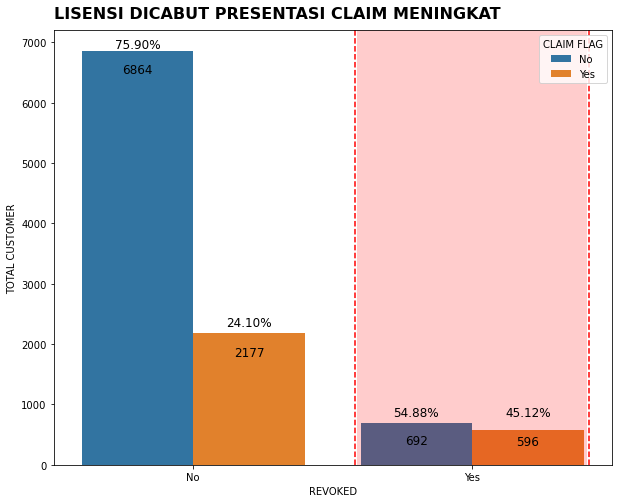

In [43]:
plt.figure(figsize=(10,8))
sns.barplot(x='REVOKED', y='TOTAL CUSTOMER',hue='CLAIM FLAG', data=revoked_claim);
plt.axvline(x=1.42, linestyle='dashed', color='red');
plt.axvline(x=0.58,linestyle='dashed', color = 'red');
plt.axvline(x=1, linewidth=230, color='red', alpha=0.2);

# # plt.text(x=revoked_claim['REVOKED'][0],x=0, y=6900, s='6864', ha='center', color='black',fontsize=12);
# plt.text(x=0.2,y=2300, s='24.10%', ha='center', color='black',fontsize=12);
# plt.text(x=1.2,y=800, s='45.12%', ha='center', color='black',fontsize=12);
# # plt.text(x=revoked_claim['PaymentMethod'][2],y=77, s='76', ha='center', color='black',fontsize=12);
# # plt.text(x=revoked_claim['PaymentMethod'][3],y=45, s='44', ha='center', color='black',fontsize=12);

# plt.text(x=-0.5,y=8300, s='LISENSI DICABUT PRESENTASI CLAIM MENINGKAT', weight='bold',ha='left', color='black',fontsize=16);
# plt.text(x=-0.5,y=7500, s='Sekitar 45.12 % customer yang lisensi berkendara nya dicabut melakukan claim \nhal ini menunjukan customer tersebut kurang memiliki kesadaran safety driving\nsehingga mereka cenderung lebih sering mengalami kerusakan pada mobilnya', ha='left', color='black',fontsize=12);

plt.text(x=-0.5,y=7400, s='LISENSI DICABUT PRESENTASI CLAIM MENINGKAT', weight='bold',ha='left', color='black',fontsize=16);

plt.text(x=0.2,y=2300, s='24.10%', ha='center', color='black',fontsize=12);
plt.text(x=-0.2,y=6900, s='75.90%', ha='center', color='black',fontsize=12);
plt.text(x=-0.2,y=6500, s='6864', ha='center', color='black',fontsize=12);
plt.text(x=0.2,y=1800, s='2177', ha='center', color='black',fontsize=12);
plt.text(x=1.2,y=800, s='45.12%', ha='center', color='black',fontsize=12);
plt.text(x=0.8,y=350, s='692', ha='center', color='black',fontsize=12);
plt.text(x=1.2,y=320, s='596', ha='center', color='black',fontsize=12);
plt.text(x=0.8,y=800, s='54.88%', ha='center', color='black',fontsize=12);

Dari data diatas dapat dilihat customer yang Revoked memiliki tingkat presentasi claim sebesar 45.12%. Hal ini menunjukan tingkat claim customer yang lisensi berkendara nya dicabut lebih tinggi dari yang masih memiliki lisensi.

# Feature Engineering

In [44]:
# Binarize into boolean: `KIDSDRIV`, `HOMEKIDS`
kids           = ["KIDSDRIV", "HOMEKIDS"]
kids_cat       = ["any_{}".format(kid) for kid in kids]
data[kids_cat] = data[kids].apply(
    lambda col: [True if i > 0 else False for i in col]
)

# Categorize based on quartiles: all excepts `CLM_AMT`
num2cat = numerics.copy()
num2cat.remove("KIDSDRIV"); num2cat.remove("HOMEKIDS");#num2cat.remove("CLM_AMT")
for col in num2cat:
    colname = "cat_{}".format(col)
    category = np.nanquantile(data[col], q=[0, 0.7, 0.8, 0.9, 1])
    data[colname] = pd.cut(
        data[col], bins=category, labels=False, include_lowest=True
    )

In [45]:
# Label encode values with two unique values
label = LabelEncoder()
data["lab_GENDER"] = label.fit_transform(data.GENDER)

In [46]:
# Ordinal encoder for ordinal data (education)
edu_rank = {
    "<High School" : 0, "High School" : 1, "Bachelors" : 2, "Masters" : 3, "PhD" : 4
}

data["lab_EDU"] = data.EDUCATION.replace(edu_rank)

In [47]:
# One-hot encoding
data = pd.concat([data, pd.get_dummies(data.OCCUPATION, prefix="job")], axis=1)
data = pd.concat([data, pd.get_dummies(data.CAR_USE, prefix="use")], axis=1)
data = pd.concat([data, pd.get_dummies(data.CAR_TYPE, prefix="type")], axis=1)

In [48]:
# Replace categorical data
cat2num = data.select_dtypes("category").columns
data[cat2num] = data[cat2num].astype("float")

In [49]:
# Manually assign numeric data to group
data["AGE_GROUP"] = pd.cut(
    data.AGE, bins=[0, 24, 40, 56, 80],
    labels=["Gen Z", "Millenial", "Gen X", "Baby boomer"],
    include_lowest=True
)

data = pd.concat(
    [data, pd.get_dummies(data.AGE_GROUP)], axis=1
)

In [50]:
# Manually assign categorical data to group
data["is_minivan"] = np.where(data.CAR_TYPE=="Minivan", True, False)

# Exploratory Data Analysis 2

## Age & Current Claim

Insight 3 


*   Gen Z = 6-24 tahun
*   Milennial = 25-40 tahun
*   Gen X = 41-56 tahun
*   Baby Boomer = > 57 tahun

In [51]:
age_claim1 = data.groupby(['CLAIM_FLAG','AGE_GROUP']).agg({'ID':['count']}
).reset_index()
age_claim1

,CLAIM_FLAG,AGE_GROUP,ID
,,,count
0,False,Gen Z,33
1,False,Millenial,2066
2,False,Gen X,4862
3,False,Baby boomer,593
4,True,Gen Z,55
5,True,Millenial,1049
6,True,Gen X,1340
7,True,Baby boomer,296


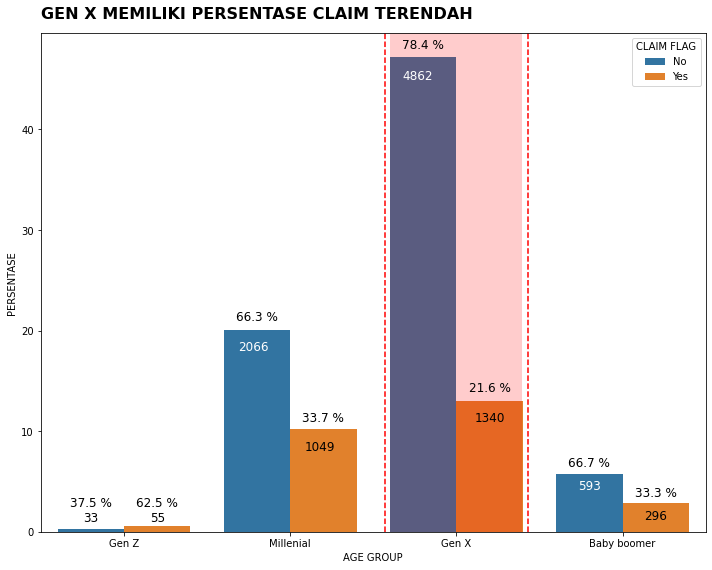

In [52]:
age_claim1 = data.groupby(['CLAIM_FLAG','AGE_GROUP']).agg({'ID':['count']}
).reset_index()

age_claim1.columns=['CLAIM FLAG','AGE GROUP','TOTAL CUSTOMER']
age_claim1

age_claim1['PERSENTASE']=(age_claim1['TOTAL CUSTOMER']/(age_claim1['TOTAL CUSTOMER'].sum()))*100

age_claim1['CLAIM FLAG'].replace(False,'No',inplace=True)
age_claim1['CLAIM FLAG'].replace(True,'Yes',inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(x='AGE GROUP', y='PERSENTASE',hue='CLAIM FLAG', data=age_claim1);
plt.axvline(x=1.57, linestyle='dashed', color='red');
plt.axvline(x=2.43,linestyle='dashed', color = 'red');
plt.axvline(x=2, linewidth=132, color='red', alpha=0.2);

#plt.text(x=revoked_claim['REVOKED'][0],x=0, y=6900, s='6864', ha='center', color='black',fontsize=12);
plt.text(x=0.2,y=2.5, s='62.5 %', ha='center', color='black',fontsize=12);
plt.text(x=-0.2,y=2.5, s='37.5 %', ha='center', color='black',fontsize=12);
plt.text(x=1.2,y=11, s='33.7 %', ha='center', color='black',fontsize=12);
plt.text(x=0.8,y=21, s='66.3 %', ha='center', color='black',fontsize=12);
plt.text(x=2.2,y=14, s='21.6 %', ha='center', color='black',fontsize=12);
plt.text(x=1.8,y=48, s='78.4 %', ha='center', color='black',fontsize=12);
plt.text(x=3.2,y=3.5, s='33.3 %', ha='center', color='black',fontsize=12);
plt.text(x=2.8,y=6.5, s='66.7 %', ha='center', color='black',fontsize=12);

plt.text(x=0.2,y=1, s='55', ha='center', color='black',fontsize=12);
plt.text(x=-0.2,y=1, s='33', ha='center', color='black',fontsize=12);
plt.text(x=1.18,y=8.1, s='1049', ha='center', color='black',fontsize=12);
plt.text(x=0.78,y=18, s='2066', ha='center', color='white',fontsize=12);
plt.text(x=2.2,y=11, s='1340', ha='center', color='black',fontsize=12);
plt.text(x=1.77,y=45, s='4862', ha='center', color='white',fontsize=12);
plt.text(x=3.2,y=1.2, s='296', ha='center', color='black',fontsize=12);
plt.text(x=2.8,y=4.2, s='593', ha='center', color='white',fontsize=12);

plt.text(x=-0.5,y=51, s='GEN X MEMILIKI PERSENTASE CLAIM TERENDAH', weight='bold',ha='left', color='black',fontsize=16);
#plt.text(x=-0.5,y=51, s='Dibandingkan generasi lainnya, persentase customer Gen X yang melakukan claim paling rendah (21.6%).', ha='left', color='black',fontsize=12);

plt.tight_layout()
plt.savefig('age.png', tight_box=True);

In [53]:
data.drop("AGE_GROUP", axis=1, inplace=True)

## Proportional Difference

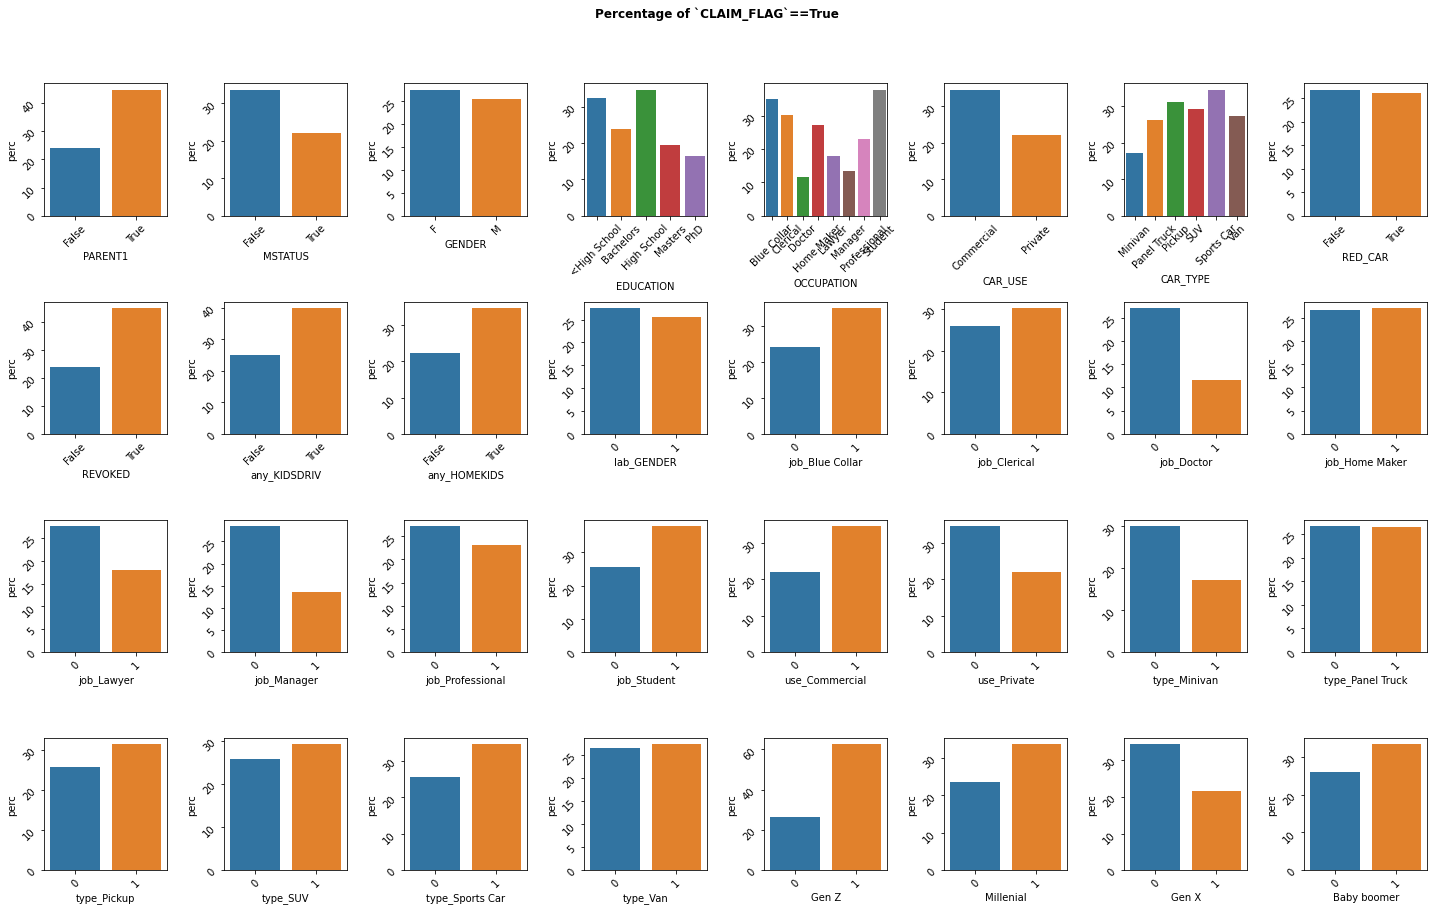

In [54]:
# Proportional difference on categorical data
categorical = data.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
categorical.remove("CLAIM_FLAG")

# Looping to create figures on proportional difference
nrow    = 4
ncol    = 8
rows    = [0]*ncol + [1]*ncol + [2]*ncol + [3]*ncol
cols    = [i for i in range(ncol)]*nrow
fig, ax = plt.subplots(nrow, ncol, figsize=[20, 12])

for row, col, cat in zip(rows, cols, categorical):
    # Create a pivot table
    pivot = pd.pivot_table(
        data, values="ID", index=cat, columns="CLAIM_FLAG", aggfunc="count"
    ).reset_index()

    # Calculate the total and percentage
    pivot["total"] = pivot[False] + pivot[True]
    pivot["perc"]  = pivot[True] / pivot["total"] * 100

    # Create a bar plot
    sns.barplot(x=cat, y="perc", data=pivot, ax=ax[row, col])
    ax[row, col].tick_params(labelrotation=45)

fig.suptitle("Percentage of `CLAIM_FLAG`==True", y=1.05, fontweight='bold')
plt.tight_layout(pad=1)
plt.show()

# Handling NA & Scaling

In [55]:
# Fill NA as 0 due to the exlusivitiy of `pd.cut`
categorized       = ["cat_{}".format(col) for col in num2cat]
data[categorized] = data[categorized].fillna(0)

# Drop NA column
data_nona = data.dropna()
data_nona = data_nona.select_dtypes(exclude="string")

In [56]:
data_nona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7652 entries, 0 to 10301
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                7652 non-null   int64  
 1   KIDSDRIV          7652 non-null   int64  
 2   AGE               7652 non-null   float64
 3   HOMEKIDS          7652 non-null   int64  
 4   YOJ               7652 non-null   float64
 5   INCOME            7652 non-null   float64
 6   PARENT1           7652 non-null   bool   
 7   HOME_VAL          7652 non-null   float64
 8   MSTATUS           7652 non-null   bool   
 9   TRAVTIME          7652 non-null   int64  
 10  BLUEBOOK          7652 non-null   float64
 11  TIF               7652 non-null   int64  
 12  RED_CAR           7652 non-null   bool   
 13  OLDCLAIM          7652 non-null   float64
 14  CLM_FREQ          7652 non-null   int64  
 15  REVOKED           7652 non-null   bool   
 16  MVR_PTS           7652 non-null   int64  

In [57]:
cat_freq = pd.pivot_table(
    data_nona,
    values="CLM_FREQ",
    index="cat_CLM_FREQ",
    columns=["CLAIM_FLAG"],
    aggfunc="count"
).reset_index()
cat_freq["total"] = cat_freq[True] + cat_freq[False]
cat_freq

CLAIM_FLAG,cat_CLM_FREQ,False,True,total
0,0,4441,1215,5656
1,1,632,449,1081
2,2,414,317,731
3,3,108,76,184


In [58]:
# Split to training and testing dataset
x = data_nona.drop(["CLAIM_FLAG", "CLM_AMT", "ID"], axis=1)
y = data_nona.CLAIM_FLAG

xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.3, random_state=seed
)

In [59]:
# Scale into Z distribution
scaler = StandardScaler()
scaler.fit(xtrain)

xtrain_std = scaler.transform(xtrain)
xtest_std  = scaler.transform(xtest)

# Handling imbalanced data

In [60]:
# Resolve imbalanced class
sampler = RandomUnderSampler()
xtrain_sample, ytrain_sample = sampler.fit_resample(xtrain_std, ytrain)

# Modelling & Evaluation

In [61]:
# Create dictionary of models
models = {
    "logreg" : LogisticRegression,
    "dt"     : DecisionTreeClassifier,
    "rf"     : RandomForestClassifier,
    "knn"    : KNeighborsClassifier
}

# Looping to fit and evaluate model
sep = "\n=============================================================\n"

for modname, mod in models.items():
    print(sep, modname)
    model = mod()
    model = model.fit(xtrain_sample, ytrain_sample)
    yhat  = model.predict(xtest_std)
    auc   = roc_auc_score(ytest, yhat)
    cv    = cross_val_score(model, xtrain_sample, ytrain_sample, cv=10)
    print(classification_report(ytest, yhat))
    print("CV : ", round(np.mean(cv), 2))
    print("AUC: ", round(auc, 2))


 logreg
              precision    recall  f1-score   support

       False       0.87      0.69      0.77      1653
        True       0.48      0.73      0.58       643

    accuracy                           0.70      2296
   macro avg       0.67      0.71      0.67      2296
weighted avg       0.76      0.70      0.71      2296

CV :  0.71
AUC:  0.71

 dt
              precision    recall  f1-score   support

       False       0.80      0.62      0.70      1653
        True       0.38      0.60      0.47       643

    accuracy                           0.61      2296
   macro avg       0.59      0.61      0.58      2296
weighted avg       0.68      0.61      0.63      2296

CV :  0.6
AUC:  0.61

 rf
              precision    recall  f1-score   support

       False       0.86      0.68      0.76      1653
        True       0.47      0.72      0.57       643

    accuracy                           0.69      2296
   macro avg       0.66      0.70      0.66      2296
weighted avg

In [62]:
# Hyperparameter tuning on the best performing model
hparams = {
    "tol"          : np.arange(1e-6, 1e-4, 1e-5),
    "C"            : np.arange(0.7, 0.85, 0.02),
    "class_weight" : [{True:i, False:j}
        for i, j in zip(np.arange(1, 1.4, 0.01), np.arange(1.4, 1, -0.01))
    ] + [{True:1, False:1}] # Default
}

logreg = LogisticRegression(solver="lbfgs")
tuned  = RandomizedSearchCV(
    logreg, hparams, cv=10, scoring="accuracy", random_state=seed
)

tuned.fit(xtrain_sample, ytrain_sample)

yhat   = tuned.predict(xtest_std)
auc    = roc_auc_score(ytest, yhat)

print(classification_report(ytest, yhat))
print("AUC: ", round(auc, 2))

              precision    recall  f1-score   support

       False       0.85      0.78      0.81      1653
        True       0.53      0.64      0.58       643

    accuracy                           0.74      2296
   macro avg       0.69      0.71      0.69      2296
weighted avg       0.76      0.74      0.74      2296

AUC:  0.71


In [63]:
# Create an ensemble model
estimator = [
    ("dt",  DecisionTreeClassifier()),
    ("knn", KNeighborsClassifier()),
    ("xgb", XGBClassifier())
]

final_est = LogisticRegression(
    C=0.7, class_weight={True:1.32, False:1.08}, tol=1e-6
)

model     = StackingClassifier(
    estimators=estimator, final_estimator=final_est, cv=10
)

model.fit(xtrain_sample, ytrain_sample)

yhat   = model.predict(xtest_std)
auc    = roc_auc_score(ytest, yhat)

print(classification_report(ytest, yhat))
print("AUC: ", round(auc, 2))

model.score(xtrain_std, ytrain)
model.score(xtest_std, ytest)

[20:14:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.6598432055749129

In [64]:
# Logistic regression with best fitting tuning parameter
logreg = LogisticRegression(
    C=0.7, class_weight={True:1.32, False:1.08}, tol=1e-6
)

logreg.fit(xtrain_sample, ytrain_sample)

yhat   = logreg.predict(xtest_std)
auc    = roc_auc_score(ytest, yhat)

print(classification_report(ytest, yhat))
print("AUC: ", round(auc, 2))

              precision    recall  f1-score   support

       False       0.88      0.62      0.73      1653
        True       0.45      0.78      0.57       643

    accuracy                           0.67      2296
   macro avg       0.66      0.70      0.65      2296
weighted avg       0.76      0.67      0.68      2296

AUC:  0.7


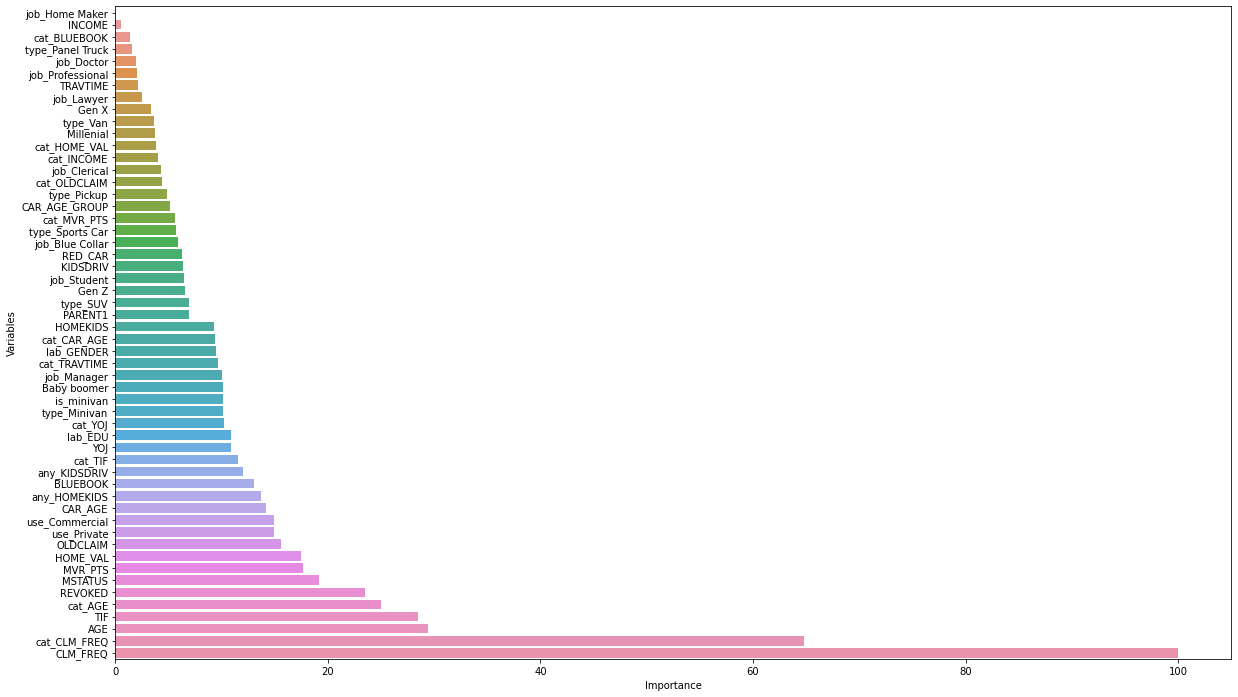

In [65]:
# Feature importance
var_imp = abs(logreg.coef_[0])
var_imp = 100 * (var_imp / var_imp.max())
col_imp = x.columns[np.argsort(var_imp)]

tbl_imp = pd.DataFrame({
    "Variables"  : col_imp,
    "Importance" : var_imp[np.argsort(var_imp)]
})

plt.figure(figsize=[20, 12])
sns.barplot(x="Importance", y="Variables", data=tbl_imp)
plt.show()